# NLP PROJECT

Analysis of Customer Reviews for Various Brands

### Loading the necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.offline as py
color = sns.color_palette()
import plotly.graph_objs as go
import plotly.tools as tls
from wordcloud import WordCloud
import gensim
from gensim import corpora
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from spellchecker import SpellChecker
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import plotly.express as px


In [ ]:
import spacy

nlp = spacy.load('en_core_web_sm')

In [ ]:
from nltk.stem.snowball import SnowballStemmer

In [ ]:
stemmer = SnowballStemmer(language='english')

### Loading the dataset

In [ ]:
df=pd.read_csv('GrammarandProductReviews.csv')
df.head()

,id,brand,categories,dateAdded,dateUpdated,ean,keys,manufacturer,manufacturerNumber,name,...,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,upc
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",2017-07-25T00:52:42Z,2018-02-05T08:36:58Z,6.02537E+11,"602537205981,universalmusic/14331328,universal...",Universal Music Group / Cash Money,14331328,Pink Friday: Roman Reloaded Re-Up (w/dvd),...,NaN,0.0,5,https://redsky.target.com/groot-domain-api/v1/...,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,Joshua,6.02537E+11
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",2017-07-25T05:16:03Z,2018-02-05T11:27:45Z,73416000391,lundbergorganiccinnamontoastricecakes/b000fvzw...,Lundberg,574764,Lundberg Organic Cinnamon Toast Rice Cakes,...,100209113.0,NaN,5,https://www.walmart.com/reviews/product/29775278,Good flavor. This review was collected as part...,Good,NaN,NaN,Dorothy W,73416000391
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",2017-07-25T05:16:03Z,2018-02-05T11:27:45Z,73416000391,lundbergorganiccinnamontoastricecakes/b000fvzw...,Lundberg,574764,Lundberg Organic Cinnamon Toast Rice Cakes,...,100209113.0,NaN,5,https://www.walmart.com/reviews/product/29775278,Good flavor.,Good,NaN,NaN,Dorothy W,73416000391
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",2017-07-25T16:26:19Z,2018-02-05T11:25:51Z,67981934427,"kylovesensualitypleasuregel/b00u2whx8s,0679819...",K-Y,67981934427,K-Y Love Sensuality Pleasure Gel,...,113026909.0,NaN,1,https://www.walmart.com/reviews/product/43383370,I read through the reviews on here before look...,Disappointed,NaN,NaN,Rebecca,67981934427
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",2017-07-25T16:26:19Z,2018-02-05T11:25:51Z,67981934427,"kylovesensualitypleasuregel/b00u2whx8s,0679819...",K-Y,67981934427,K-Y Love Sensuality Pleasure Gel,...,171267657.0,NaN,1,https://www.walmart.com/reviews/product/43383370,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,Walker557,67981934427


## Part 1 : Understanding the dataset

### Basic EDA

In [ ]:
df = df.dropna(subset=['reviews.text'])

In [ ]:
df.dtypes

id                       object
brand                    object
categories               object
dateAdded                object
dateUpdated              object
ean                      object
keys                     object
manufacturer             object
manufacturerNumber       object
name                     object
reviews.date             object
reviews.dateAdded        object
reviews.dateSeen         object
reviews.didPurchase      object
reviews.doRecommend      object
reviews.id              float64
reviews.numHelpful      float64
reviews.rating            int64
reviews.sourceURLs       object
reviews.text             object
reviews.title            object
reviews.userCity         object
reviews.userProvince     object
reviews.username         object
upc                      object
dtype: object

In [ ]:
df.isnull().sum()

id                          0
brand                       0
categories                  0
dateAdded                   0
dateUpdated                 0
ean                     31979
keys                        0
manufacturer              141
manufacturerNumber        203
name                        0
reviews.date               67
reviews.dateAdded           0
reviews.dateSeen            0
reviews.didPurchase     38886
reviews.doRecommend     10615
reviews.id              38886
reviews.numHelpful      38536
reviews.rating              0
reviews.sourceURLs          0
reviews.text               36
reviews.title             476
reviews.userCity        65634
reviews.userProvince    70595
reviews.username           96
upc                         2
dtype: int64

In [ ]:
cnt_srs = df['reviews.rating'].value_counts().head()
trace = go.Bar(
    y=cnt_srs.index[::-1],
    x=cnt_srs.values[::-1],
    orientation = 'h',
    marker=dict(
        color=cnt_srs.values[::-1],
        colorscale = 'Blues',
        reversescale = True
    ),
)

layout = dict(
    title='Ratings distribution',
    )
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="Ratings")

In [ ]:
df['reviews_length']=df['reviews.text'].apply(len)

In [ ]:
avg_length_by_rating = df.groupby('reviews.rating')['reviews_length'].mean()

<AxesSubplot: xlabel='reviews.rating'>

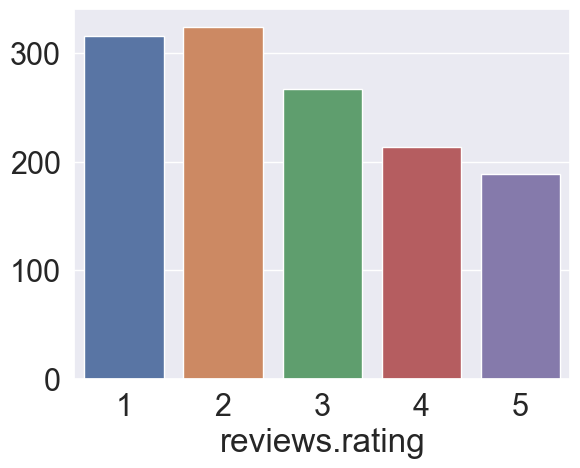

In [ ]:
sns.barplot(x=avg_length_by_rating.index, y=avg_length_by_rating.values)

In [ ]:
df.iloc[1].values

array(['AV14LG0R-jtxr-f38QfS', 'Lundberg',
       'Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes',
       '2017-07-25T05:16:03Z', '2018-02-05T11:27:45Z', '73416000391',
       'lundbergorganiccinnamontoastricecakes/b000fvzw8y,lundbergorganiccinnamontoastricecakes/b005grcqwc,073416000391,lundbergorganiccinnamontoastricecakes/b0013jlzbu,0073416000391,lundbergorganiccinnamontoastricecakes/555222704,lundberg/00574764,lundbergorganiccinnamontoastricecakes/563800996',
       'Lundberg', '574764', 'Lundberg Organic Cinnamon Toast Rice Cakes',
       '2017-07-09T00:00:00.000Z', '2017-09-23T02:53:06Z',
       '2017-09-16T09:45:00.000Z', True, nan, 100209113.0, nan, 5,
       'https://www.walmart.com/reviews/product/29775278',
       'Good flavor. This review was collected as part of a promotion.',
       'Good', nan, nan, 'Dorothy W', '73416000391', 62], dtype=object)

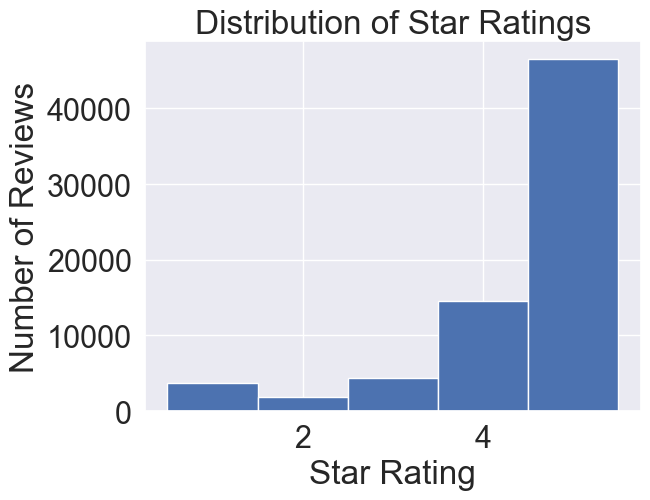

In [ ]:
# Create a histogram of the star ratings
df['reviews.rating'].hist(bins=5, range=(0.5, 5.5), align='mid')

# Set the axis labels and title
plt.xlabel('Star Rating')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Star Ratings')

# Show the plot
plt.show()

## Advanced EDA

Names of all the columns 

In [ ]:
import pandas as pd

data = pd.read_csv('GrammarandProductReviews.csv') 

print(data.columns)


Index(['id', 'brand', 'categories', 'dateAdded', 'dateUpdated', 'ean', 'keys',
       'manufacturer', 'manufacturerNumber', 'name', 'reviews.date',
       'reviews.dateAdded', 'reviews.dateSeen', 'reviews.didPurchase',
       'reviews.doRecommend', 'reviews.id', 'reviews.numHelpful',
       'reviews.rating', 'reviews.sourceURLs', 'reviews.text', 'reviews.title',
       'reviews.userCity', 'reviews.userProvince', 'reviews.username', 'upc'],
      dtype='object')


Cleaning the dataset

In [ ]:
import pandas as pd
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Load the CSV file
data = pd.read_csv('GrammarandProductReviews.csv')  # Replace 'path_to_dataset.csv' with the actual file path

# Clean the text
data['cleaned_reviews'] = data['reviews.didPurchase'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x)))  # Remove special characters
data['cleaned_reviews'] = data['cleaned_reviews'].apply(lambda x: re.sub(r'\d+', '', str(x)))  # Remove numbers

# Normalize the text
data['cleaned_reviews'] = data['cleaned_reviews'].apply(lambda x: x.lower())  # Convert to lowercase

# Tokenize the text
data['tokenized_reviews'] = data['cleaned_reviews'].apply(word_tokenize)  # Tokenize the text

# Remove stopwords
stop_words = set(stopwords.words('english'))
data['tokenized_reviews'] = data['tokenized_reviews'].apply(lambda x: [word for word in x if word not in stop_words])

# Lemmatize the text
lemmatizer = WordNetLemmatizer()
data['tokenized_reviews'] = data['tokenized_reviews'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

# Remove rows with null values
data.dropna(subset=['cleaned_reviews'], inplace=True)

# Display the preprocessed data
print(data.head())


                     id            brand  \
0  AV13O1A8GV-KLJ3akUyj  Universal Music   
1  AV14LG0R-jtxr-f38QfS         Lundberg   
2  AV14LG0R-jtxr-f38QfS         Lundberg   
3  AV16khLE-jtxr-f38VFn              K-Y   
4  AV16khLE-jtxr-f38VFn              K-Y   

                                          categories             dateAdded  \
0  Movies, Music & Books,Music,R&b,Movies & TV,Mo...  2017-07-25T00:52:42Z   
1  Food,Packaged Foods,Snacks,Crackers,Snacks, Co...  2017-07-25T05:16:03Z   
2  Food,Packaged Foods,Snacks,Crackers,Snacks, Co...  2017-07-25T05:16:03Z   
3  Personal Care,Medicine Cabinet,Lubricant/Sperm...  2017-07-25T16:26:19Z   
4  Personal Care,Medicine Cabinet,Lubricant/Sperm...  2017-07-25T16:26:19Z   

            dateUpdated          ean  \
0  2018-02-05T08:36:58Z  6.02537E+11   
1  2018-02-05T11:27:45Z  73416000391   
2  2018-02-05T11:27:45Z  73416000391   
3  2018-02-05T11:25:51Z  67981934427   
4  2018-02-05T11:25:51Z  67981934427   

                         

To check for common words used so as to determine what topics people were writing about 

In [ ]:
import nltk
from nltk import FreqDist

# Concatenate all tokenized reviews into a single list
all_reviews = [word for sublist in data['tokenized_reviews'] for word in sublist]

# Calculate word frequency
freq_dist = FreqDist(all_reviews)

# Get the most common words
most_common_words = freq_dist.most_common(10)  # Change the number to get more or fewer words

# Display the most common words
for word, count in most_common_words:
    print(word, ':', count)


nan : 38886
false : 28476
true : 3682


In [ ]:
!pip install wordcloud

In [ ]:
pip install matplotlib


Note: you may need to restart the kernel to use updated packages.


In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_reviews_text = ' '.join(data['reviews.didPurchase'].dropna().astype(str))

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews_text)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [ ]:
max_ratings = data['reviews.rating'].max()
print("Maximum number of ratings:", max_ratings)


Maximum number of ratings: 5


In [ ]:
Sentiment analysis 

In [ ]:
!pip install textblob


In [ ]:
from textblob import TextBlob

def get_sentiment(text):
    if isinstance(text, str):
        return TextBlob(text).sentiment.polarity
    else:
        return None

data['sentiment'] = data['reviews.text'].apply(get_sentiment)

# Display the sentiment polarity of each review
print(data[['reviews.text', 'sentiment']])


                                            reviews.text  sentiment
0      i love this album. it's very good. more to the...   0.222857
1      Good flavor. This review was collected as part...   0.700000
2                                           Good flavor.   0.700000
3      I read through the reviews on here before look...  -0.040109
4      My husband bought this gel for us. The gel cau...   0.000000
...                                                  ...        ...
71039  I'm dealing with dry eyes and very sensitive t...  -0.046667
71040  Great stuff! Helps keep my contacts moist all ...   1.000000
71041                                        Right price   0.285714
71042  I was so pleased when this scarf arrived for m...   0.306771
71043  Excellent album, makes the holidays better, gi...   0.700000

[71044 rows x 2 columns]


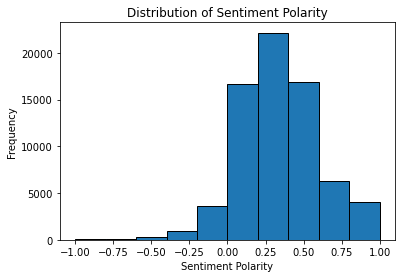

In [ ]:
import matplotlib.pyplot as plt

filtered_data = data.dropna(subset=['sentiment'])

plt.hist(filtered_data['sentiment'], bins=10, edgecolor='black')

# Set labels and title
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Polarity')

# Display the histogram
plt.show()


In [ ]:
!pip install gensim

In [ ]:
import pandas as pd
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel

# Load the data
data = pd.read_csv('GrammarandProductReviews.csv')

# Remove rows with missing values in the 'reviews.text' column
data.dropna(subset=['reviews.text'], inplace=True)

# Create a list of tokenized reviews
tokenized_reviews = data['reviews.text'].apply(lambda x: x.lower().split())

# Create a dictionary representation of the reviews
dictionary = Dictionary(tokenized_reviews)

# Filter out tokens that appear in less than 10% of the reviews or more than 50% of the reviews
dictionary.filter_extremes(no_below=len(tokenized_reviews)*0.1, no_above=0.5)

# Create a bag-of-words representation of the reviews
corpus = [dictionary.doc2bow(review) for review in tokenized_reviews]

# Train the LDA model with 5 topics
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5)

# Print the top 10 words for each topic
for i, topic in lda_model.show_topics(num_topics=5, num_words=10, formatted=False):
    print('Topic {}: {}'.format(i+1, ', '.join([word[0] for word in topic])))


Topic 1: is, it, for, have, that, not, to, they, my, but
Topic 2: was, good, as, very, it, but, not, of, to, really
Topic 3: as, of, was, part, review, collected, promotion., my, to, product
Topic 4: movie, great, for, is, to, you, of, with, all, are
Topic 5: to, my, it, of, in, on, have, with, for, was


Authenticity of reviews: This was to check the number of real reviews so as to get more accurate information. 

In [ ]:
import pandas as pd
from textblob import TextBlob

# Load the review data into a DataFrame
data = pd.read_csv('GrammarandProductReviews.csv')

# Function to check for overly positive or negative reviews
def check_fake_reviews(review):
    if isinstance(review, str):
        blob = TextBlob(review)
        polarity = blob.sentiment.polarity
        if polarity > 0.8 or polarity < -0.8:
            return 'Potential Fake'
    return 'Authentic'

# Apply the function to each review in the DataFrame
data['review_authenticity'] = data['reviews.text'].apply(check_fake_reviews)

# Print the results
print(data[['reviews.text', 'review_authenticity']])


                                            reviews.text review_authenticity
0      i love this album. it's very good. more to the...           Authentic
1      Good flavor. This review was collected as part...           Authentic
2                                           Good flavor.           Authentic
3      I read through the reviews on here before look...           Authentic
4      My husband bought this gel for us. The gel cau...           Authentic
...                                                  ...                 ...
71039  I'm dealing with dry eyes and very sensitive t...           Authentic
71040  Great stuff! Helps keep my contacts moist all ...      Potential Fake
71041                                        Right price           Authentic
71042  I was so pleased when this scarf arrived for m...           Authentic
71043  Excellent album, makes the holidays better, gi...           Authentic

[71044 rows x 2 columns]


Comparining brands to be able to give insights to the choosen brands on how they compare to each other and what might be the diffrence between their failure and their competetors success. 

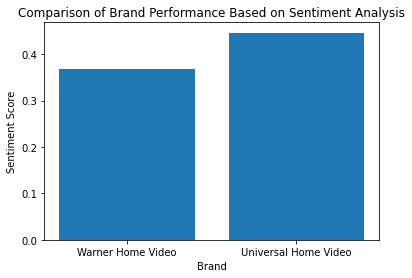

In [ ]:
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt

# Filter the reviews for Brand A
brand_a_reviews = data[data['brand'] == 'Warner Home Video']['reviews.text']

# Filter the reviews for Brand B
brand_b_reviews = data[data['brand'] == 'Universal Home Video']['reviews.text']

# Perform sentiment analysis for Brand A
brand_a_sentiments = brand_a_reviews.apply(lambda x: TextBlob(x).sentiment.polarity)

# Perform sentiment analysis for Brand B
brand_b_sentiments = brand_b_reviews.apply(lambda x: TextBlob(x).sentiment.polarity)

# Calculate the average sentiment polarity for Brand A
brand_a_avg_sentiment = brand_a_sentiments.mean()

# Calculate the average sentiment polarity for Brand B
brand_b_avg_sentiment = brand_b_sentiments.mean()

# Create a DataFrame to store the results
brand_performance = pd.DataFrame({
    'Brand': ['Warner Home Video', 'Universal Home Video'],
    'Sentiment Score': [brand_a_avg_sentiment, brand_b_avg_sentiment]
})

# Visualize the brand performance
plt.bar(brand_performance['Brand'], brand_performance['Sentiment Score'])
plt.xlabel('Brand')
plt.ylabel('Sentiment Score')
plt.title('Comparison of Brand Performance Based on Sentiment Analysis')
plt.show()


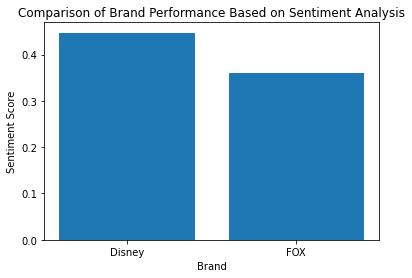

In [ ]:
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt

brand_a_reviews = data[data['brand'] == 'Disney']['reviews.text']

brand_b_reviews = data[data['brand'] == 'FOX']['reviews.text']

brand_a_sentiments = brand_a_reviews.apply(lambda x: TextBlob(x).sentiment.polarity)

brand_b_sentiments = brand_b_reviews.apply(lambda x: TextBlob(x).sentiment.polarity)

brand_a_avg_sentiment = brand_a_sentiments.mean()


brand_b_avg_sentiment = brand_b_sentiments.mean()


brand_performance = pd.DataFrame({
    'Brand': ['Disney', 'FOX'],
    'Sentiment Score': [brand_a_avg_sentiment, brand_b_avg_sentiment]
})

plt.bar(brand_performance['Brand'], brand_performance['Sentiment Score'])
plt.xlabel('Brand')
plt.ylabel('Sentiment Score')
plt.title('Comparison of Brand Performance Based on Sentiment Analysis')
plt.show()


In [ ]:
from textblob import TextBlob

# Example
text = "This product is amazing! I love it!"

# Create a TextBlob object
blob = TextBlob(text)

# Calculate the sentiment polarity
sentiment_score = blob.sentiment.polarity

# Print the sentiment score
print(sentiment_score)


0.6875


In [ ]:
from textblob import TextBlob

# Function to calculate sentiment score for a review
def calculate_sentiment_score(review):
    if isinstance(review, str):
        blob = TextBlob(review)
        sentiment_score = blob.sentiment.polarity
    else:
        sentiment_score = 0  # Assign a default sentiment score for non-string values
    return sentiment_score

# Apply the function to each review in the DataFrame and create a new column 'sentiment'
data['sentiment'] = data['reviews.text'].apply(calculate_sentiment_score)

# Print the DataFrame with the added 'sentiment' column
print(data.head())


                     id            brand  \
0  AV13O1A8GV-KLJ3akUyj  Universal Music   
1  AV14LG0R-jtxr-f38QfS         Lundberg   
2  AV14LG0R-jtxr-f38QfS         Lundberg   
3  AV16khLE-jtxr-f38VFn              K-Y   
4  AV16khLE-jtxr-f38VFn              K-Y   

                                          categories             dateAdded  \
0  Movies, Music & Books,Music,R&b,Movies & TV,Mo...  2017-07-25T00:52:42Z   
1  Food,Packaged Foods,Snacks,Crackers,Snacks, Co...  2017-07-25T05:16:03Z   
2  Food,Packaged Foods,Snacks,Crackers,Snacks, Co...  2017-07-25T05:16:03Z   
3  Personal Care,Medicine Cabinet,Lubricant/Sperm...  2017-07-25T16:26:19Z   
4  Personal Care,Medicine Cabinet,Lubricant/Sperm...  2017-07-25T16:26:19Z   

            dateUpdated          ean  \
0  2018-02-05T08:36:58Z  6.02537E+11   
1  2018-02-05T11:27:45Z  73416000391   
2  2018-02-05T11:27:45Z  73416000391   
3  2018-02-05T11:25:51Z  67981934427   
4  2018-02-05T11:25:51Z  67981934427   

                         

In [ ]:
# Function to calculate sentiment score for a review
def calculate_sentiment_score(review):
    blob = TextBlob(str(review))
    sentiment_score = blob.sentiment.polarity
    return sentiment_score

# Apply the function to each review in the DataFrame and create a new column 'sentiment'
data['sentiment'] = data['reviews.text'].apply(calculate_sentiment_score)


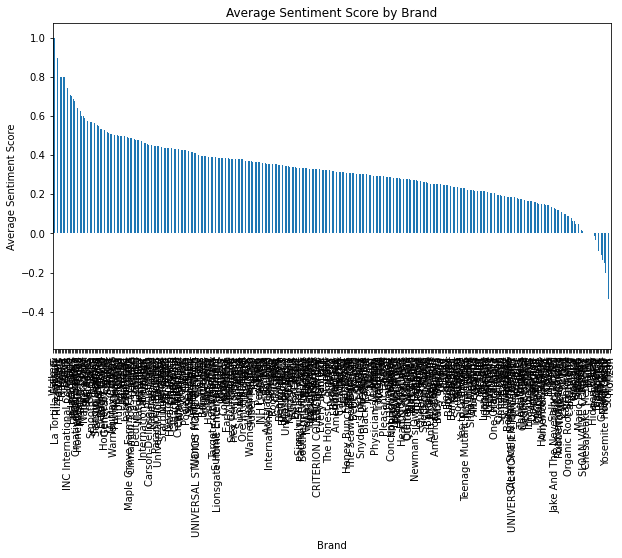

In [ ]:
# Group the data by brand and calculate the average sentiment score for each brand
brand_sentiment = data.groupby('brand')['sentiment'].mean().sort_values(ascending=False)

# Plot the bar chart
brand_sentiment.plot(kind='bar', figsize=(10, 6))
plt.title('Average Sentiment Score by Brand')
plt.xlabel('Brand')
plt.ylabel('Average Sentiment Score')
plt.show()


### Spellchecker

In [ ]:
spell = SpellChecker()

def count_spell_errors(text):
    # Split the text into words
    words = text.split()
    # Get the misspelled words
    misspelled = spell.unknown(words)
    # Count the number of misspelled words
    return len(misspelled)

df['num_spell_errors'] = df['reviews.text'].apply(count_spell_errors)

In [ ]:
avg_spell_errors_by_rating = df.groupby('reviews.rating')['num_spell_errors'].mean()

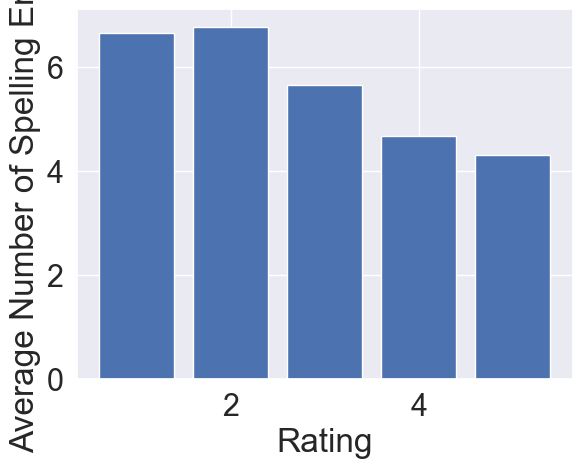

In [ ]:
plt.bar(avg_spell_errors_by_rating.index, avg_spell_errors_by_rating.values)
plt.xlabel('Rating')
plt.ylabel('Average Number of Spelling Errors')
plt.show()

### Basic word cloud and topic modelling

#### Cleaning text

In [ ]:
import string

def clean_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize text and remove stop words
    doc = nlp(text)
    tokens = [token.text for token in doc if not token.is_stop]

    # Lemmatize words
    lemmatized_tokens = [token.lemma_ for token in doc]

    # Stem words
    #stemmer = SnowballStemmer(language='english')
    #stemmed_tokens = [stemmer.stem(token) for token in tokens]
    
    # Join the stemmed tokens back into a string
    cleaned_text = " ".join(lemmatized_tokens)

    return cleaned_text

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vansh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vansh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vansh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
def clean_text(text):
    # Lowercase all text
    text = text.lower()
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    
    # Remove rare words
    
    # Join the cleaned words and return as a string
    return ' '.join(words)

In [ ]:
clean_text("I have tried this deodorant in the past and I must say that it is my favorite scent. It's the only one I have ever purchased. But this time I was lucky enough to receive it for free from Influenster as testing purposes. I don't have much to say since I have already used this product many times other than it's good and I love the smell. It's not overwhelmingly strong and also it is long lasting and it doesn't make me sweat. This review was collected as part of a promotion")

'I have try this deodorant in the past and I must say that it be my favorite scent its the only one I have ever purchase but this time I be lucky enough to receive it for free from influenster as testing purpose I do not have much to say since I have already use this product many time other than its good and I love the smell its not overwhelmingly strong and also it be long last and it do not make I sweat this review be collect as part of a promotion'

#### Testing on sampling data , to be tested on larger data

In [ ]:
#sampling
dff = df.sample(1000)

In [ ]:
# Apply the clean_text function to the 'reviews.text' column
df['reviews.text.clean'] = df['reviews.text'].apply(clean_text)

In [ ]:
dff.sample(2)

,id,brand,categories,dateAdded,dateUpdated,ean,keys,manufacturer,manufacturerNumber,name,...,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,upc,reviews.text.clean
39629,AVpgOPJHLJeJML43KwSj,Universal Home Video,"Featured Brands,Character Shop,The Secret Life...",2017-01-15T18:04:14Z,2018-02-05T10:22:44Z,NaN,"025192392665,universalhomevideo/51605670,unive...",Universal,51605670,The Secret Life Of Pets (4k/uhd + Blu-Ray + Di...,...,0.0,4,http://reviews.bestbuy.com/3545/5615602/review...,"This movie is definitely more geared for kids,...",Cute movie,NaN,NaN,kwaite,25192392665,"[movi, definit, gear, kid, 3d, version, great,..."
652,AV1l8zRZvKc47QAVhnAv,Olay,"Personal Care,Skin Care,Anti-Aging,Beauty,Face...",2017-07-21T16:20:23Z,2018-02-05T11:28:34Z,75609007408,"075609007408,olayregeneristdeephydrationregene...",P&G,10910247,Olay Regenerist Deep Hydration Regenerating Cream,...,NaN,5,https://www.walmart.com/reviews/product/103221...,ITS SUPER GOOD AND AMAZING I really like the p...,It's really mostrizing,NaN,NaN,Llwlskskakskjsjsjdj,75609007408,"[super, good, amaz, like, packag, believ, make..."


In [ ]:
df.sample(1)['reviews.text'].values[0]

"I have tried this deodorant in the past and I must say that it is my favorite scent. It's the only one I have ever purchased. But this time I was lucky enough to receive it for free from Influenster as testing purposes. I don't have much to say since I have already used this product many times other than it's good and I love the smell. It's not overwhelmingly strong and also it is long lasting and it doesn't make me sweat. This review was collected as part of a promotion."

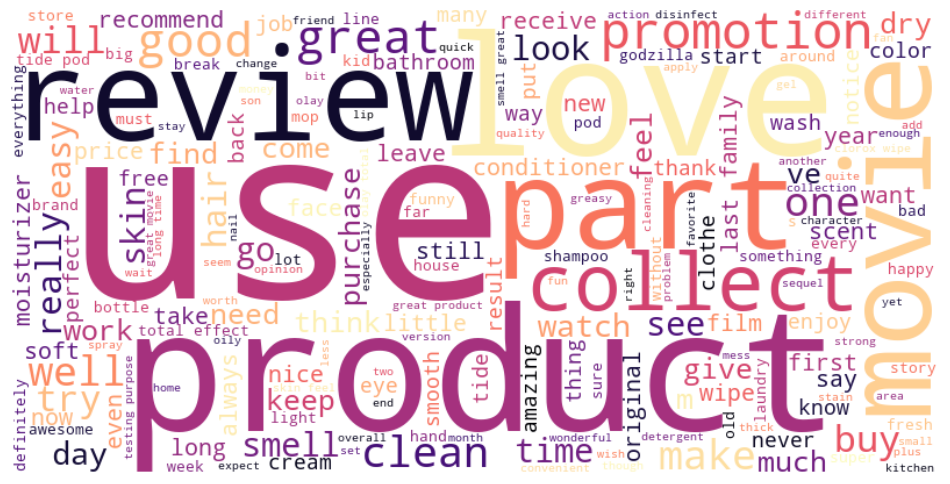

In [ ]:
text = ' '.join(dff['reviews.text.clean'].explode().values)

# Create a WordCloud object and generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='magma').generate(text)

# Display the word cloud
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
from bertopic import BERTopic


# Instantiate the Bertopic model
model = BERTopic(language='english', calculate_probabilities=True)

In [ ]:
dff['reviews.text.clean'].values

array(['keep disinfecting wipes nearby clean bathroom oftern quickly super job handy easy use',
       'great movie good first movie still great movie add collection',
       'take vacation time best way assure happy time review collected part promotion',
       'grew watching animated version give movie try',
       'great carti would buy recommend othersit arrived timewas easy put togetherand needed kitchen love color looks great kitchen',
       'start press nail person still product great achieving fast french manicure without pay salon prices final product nails looked great although bit long ended filing shaping slightly shorter overall much easier compared dry time techniques like sally hansen strips pressons used past still issues longevity didnt anything ordinary protect one nails fell within day normal use would try reserve using special occasions received free testing purposes influenster',
       'good way better 1998 godzilla matthew broderick expecting origin story anothe

In [ ]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)


In [ ]:
model.fit(df.categories.value_counts().index)

In [ ]:

model.visualize_barchart(top_n_topics=5)

### FILTERING OUT BY BRANDS above 1000

In [ ]:
df_filtered.brand.value_counts()

Clorox                  10700
Universal Home Video     6178
Tide                     5384
L'Oreal Paris            4971
FOX                      4498
Disney                   3692
Olay                     3420
Warner Home Video        3330
Sony Pictures            2161
Rubbermaid               1939
Warner Bros.             1920
Quilted Northern         1439
Lionsgate                1351
Name: brand, dtype: int64

In [ ]:
df['brand'] = df['brand'].replace("L'oreal Paris", "L'Oreal Paris")


In [ ]:
top_brands = ['Clorox', 'Universal Home Video', 'Tide', 'FOX', 'Disney', 'Olay', 'Warner Home Video', 'L\'Oreal Paris', 'Sony Pictures', 'Rubbermaid', 'Warner Bros.', 'Quilted Northern', 'Lionsgate']
df_filtered = df[df['brand'].isin(top_brands)]

In [ ]:
from transformers import pipeline, GPT2LMHeadModel, GPT2Tokenizer


In [ ]:
# Group reviews by brand name
brand_reviews = df_filtered[['brand','reviews.text']]

In [ ]:
brand_reviews.sample(10)

,brand,reviews.text
28546,Disney,Great sequel to Planes... my son absolutely lo...
39994,Universal Home Video,I bought this for my daughter and it didn't di...
59417,L'Oreal Paris,I loved the quality and effectiveness of Revit...
55065,Olay,In just a couple days I can see lines on my fa...
14876,Clorox,I love using the wipes to help clean up messes...
49702,Tide,I purchased them when they were released and I...
329,Olay,I love the regenerist deep hydration cream at ...
40423,Universal Home Video,A family friendly funny and fun movie. Many la...
24572,Warner Home Video,Better than a lot of the godzilla movies that ...
29802,L'Oreal Paris,Overall this is a decent conditioner...and I g...


## Part 2 : Deep dive into Sentimental analysis

#### Why are we doing this?
- The primary purpose of conducting sentiment analysis on customer reviews using the Transformers library is to gain valuable    insights into customer sentiment and opinions regarding different brands. By analyzing the sentiment expressed in these     reviews, you can extract meaningful information that can be used to understand customer preferences, improve products or   services, and make data-driven business decisions. 

#### What is the use of sentiment analysis in customer reviews?

Sentiment analysis offers several practical uses and benefits in analyzing customer reviews:

- Customer Insights: Sentiment analysis provides valuable insights into customer preferences, opinions, and emotions. It allows you to identify patterns, trends, and sentiments associated with specific brands, products, or services.

- Brand Perception: Analyzing sentiment in customer reviews helps you understand how your brand is perceived in the market. It provides a quantitative measure of customer satisfaction, allowing you to track changes in sentiment over time and compare it with your competitors.

- Marketing and Advertising: Sentiment analysis can guide marketing and advertising efforts. Positive sentiment can be leveraged for testimonials and promotional material, while negative sentiment can prompt adjustments to marketing strategies or targeted campaigns.

- Customer Service and Support: Sentiment analysis can highlight areas where customers may be facing issues or experiencing dissatisfaction. By identifying negative sentiment, you can proactively address customer concerns, improve customer service processes, and enhance overall customer satisfaction.

- Reputation Management: Sentiment analysis enables you to monitor and manage your brand's reputation by identifying and addressing negative sentiment promptly. It allows you to engage with customers, resolve issues, and demonstrate your commitment to customer satisfaction.


In [ ]:
sentiment_pipeline = pipeline('sentiment-analysis', model='distilbert-base-uncased-finetuned-sst-2-english',truncation=True)

loading configuration file config.json from cache at C:\Users\vansh/.cache\huggingface\hub\models--distilbert-base-uncased-finetuned-sst-2-english\snapshots\3d65bad49c7ba6f71920504507a8927f4b9db6c0\config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased-finetuned-sst-2-english",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "finetuning_task": "sst-2",
  "hidden_dim": 3072,
  "id2label": {
    "0": "NEGATIVE",
    "1": "POSITIVE"
  },
  "initializer_range": 0.02,
  "label2id": {
    "NEGATIVE": 0,
    "POSITIVE": 1
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading configuration fi

In [ ]:
sample_tweets = df_filtered['reviews.text'].head(10)


Text: This cream did not do much for my face or throat area. I have gone back to my generic brand, it works better and is not as expensive. This review was collected as part of a promotion.
Label: NEGATIVE
Score: 0.9984373450279236

Text: I used (and loved) this product for several years until they changed it. It used to moisturize my skin and left it feeling soft. Now, it sits on top of my skin and is never absorbed. It just leaves a slimy film on my skin. I will no longer purchase this product.
Label: POSITIVE
Score: 0.6605412364006042

Text: I have been using Oil of Olay for over 20 years. This product worked so well for me, but the new formula is HORRIBLE! I cannot find anything to work for my skin like it did! The smell is flowery and it is too thick. The old formula was so light
Label: NEGATIVE
Score: 0.9964169263839722

Text: I am so disappointed! I have used this product for years because of it's soft smell and great results. The new formula feels greasy, smells awful and I don

In [ ]:
df_filtered['sentiment'] = df_filtered['reviews.text'].apply(lambda x: sentiment_pipeline(x)[0]['label'])

In [ ]:
df_filtered.to_csv('with_sentiments_filter.csv')

In [ ]:
df_filtered['sentiment']

56       NEGATIVE
57       POSITIVE
58       NEGATIVE
59       NEGATIVE
60       NEGATIVE
           ...   
70247    POSITIVE
70248    POSITIVE
70249    POSITIVE
70250    POSITIVE
70251    POSITIVE
Name: sentiment, Length: 50983, dtype: object

### Relationships with the brand

In [ ]:
# Group tweets by company and sentiment label
grouped_reviews = df_filtered.groupby(['brand', 'sentiment']).size().reset_index(name='count')

# Plot number of positive and negative tweets per company
fig = px.bar(grouped_reviews, x='brand', y='count', color='sentiment', 
             title='Number of Positive and Negative reviews per Brand')
fig.show()

In [ ]:
# Group reviews by company and sentiment label
grouped_reviews = df_filtered.groupby(['brand', 'sentiment']).size().reset_index(name='count')

# Calculate total number of reviews for each brand
total_reviews = grouped_reviews.groupby('brand').sum().reset_index().rename(columns={'count': 'total'})

# Merge total_reviews with grouped_reviews
grouped_reviews = pd.merge(grouped_reviews, total_reviews, on='brand')

# Calculate proportion of positive and negative reviews for each brand
grouped_reviews['proportion'] = grouped_reviews['count'] / grouped_reviews['total']

# Filter out neutral reviews
grouped_reviews = grouped_reviews[grouped_reviews['sentiment'] != 'NEUTRAL']

# Pivot table to format data for plotting
pivoted_reviews = grouped_reviews.pivot(index='brand', columns='sentiment', values='proportion').reset_index()

# Melt pivoted table to long format
melted_reviews = pd.melt(pivoted_reviews, id_vars=['brand'], value_vars=['NEGATIVE', 'POSITIVE'], 
                         var_name='sentiment', value_name='proportion')

# Plot proportion of positive and negative reviews per company
fig = px.bar(melted_reviews, x='brand', y='proportion', color='sentiment', 
             title='Proportion of Positive and Negative reviews per Brand')
fig.show()

### Results: 
- How could it help? , would give a deeper look at which brands are performing well and which are not
- In this case , Rubbermaid has the most negetive comments , while Disney and Universal Home Video has the most positive comments.
- What could be the reason for this? how could they make it better to reduce the negetive comments?

### Looking more closer:  Topic modelling and word cloud per sentiments 

In [ ]:
# Step 2: Preprocess the text data
def preprocess(text):
    # Remove punctuations and numbers
    text = re.sub('[^a-zA-Z]', ' ', text)
    
    # Convert to lowercase and split into words
    words = text.lower().split()
    
    # Remove stopwords and lemmatize words
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer
    
    stop_words = stopwords.words('english')
    lemmatizer = WordNetLemmatizer()
    
    words = [lemmatizer.lemmatize(word) for word in words if not word in stop_words]
    
    return ' '.join(words)

df_filtered['clean_text'] = df_filtered['reviews.text'].apply(preprocess)

# Step 3: Split the data into positive and negative sentiment
pos_df = df_filtered[df_filtered['sentiment'] == 'POSITIVE']
neg_df = df_filtered[df_filtered['sentiment'] == 'NEGATIVE']




### Focusing on POSTIVE SENTIMENTS

In [ ]:
pos_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
pos_topics, probs = pos_model.fit_transform(pos_df['clean_text'].values)





loading configuration file C:\Users\vansh/.cache\torch\sentence_transformers\sentence-transformers_all-MiniLM-L6-v2\config.json
Model config BertConfig {
  "_name_or_path": "C:\\Users\\vansh/.cache\\torch\\sentence_transformers\\sentence-transformers_all-MiniLM-L6-v2\\",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file C:\Users\vansh/.cache\torch\sentence_transformers\sentence-transformers_all-MiniLM-L6-v2\pytorch_model.bin
All model ch

Batches:   0%|          | 0/1185 [00:00<?, ?it/s]

2023-05-13 14:42:18,413 - BERTopic - Transformed documents to Embeddings
2023-05-13 14:42:37,713 - BERTopic - Reduced dimensionality
2023-05-13 14:45:06,232 - BERTopic - Clustered reduced embeddings


In [ ]:
pos_model.get_topic(0)

[('skin', 0.013728403204955959),
 ('moisturizer', 0.011569162025898094),
 ('face', 0.010580193649926704),
 ('olay', 0.010019216385671558),
 ('cream', 0.008449792616191321),
 ('feel', 0.008385023856772436),
 ('aging', 0.00783814721646391),
 ('total', 0.007819314506597288),
 ('smooth', 0.007206886581034971),
 ('week', 0.007006612539888283)]

In [ ]:
pos_model.visualize_barchart(top_n_topics=5)

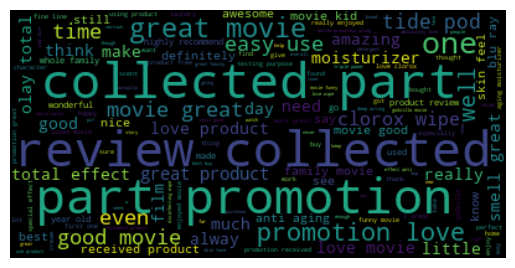

In [ ]:
# Generate the word cloud for positive sentiment
positive_cloud = WordCloud().generate(' '.join(pos_df['clean_text'].values))
plt.imshow(positive_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()



### Focus on NEGETIVE SENTIMENTS

In [ ]:
neg_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
neg_topics, probs = neg_model.fit_transform(neg_df['clean_text'].values)

loading configuration file C:\Users\vansh/.cache\torch\sentence_transformers\sentence-transformers_all-MiniLM-L6-v2\config.json
Model config BertConfig {
  "_name_or_path": "C:\\Users\\vansh/.cache\\torch\\sentence_transformers\\sentence-transformers_all-MiniLM-L6-v2\\",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file C:\Users\vansh/.cache\torch\sentence_transformers\sentence-transformers_all-MiniLM-L6-v2\pytorch_model.bin
All model ch

Batches:   0%|          | 0/409 [00:00<?, ?it/s]

2023-05-13 14:48:29,533 - BERTopic - Transformed documents to Embeddings
2023-05-13 14:48:38,083 - BERTopic - Reduced dimensionality
2023-05-13 14:48:44,967 - BERTopic - Clustered reduced embeddings


In [ ]:
neg_model.get_topic(0)

[('tide', 0.03544093515932228),
 ('pod', 0.034506330622981064),
 ('clothes', 0.027470288216088844),
 ('detergent', 0.022967781095857023),
 ('laundry', 0.020360026646406664),
 ('load', 0.018266489522155396),
 ('stain', 0.016891695006499095),
 ('liquid', 0.014598695417676081),
 ('washer', 0.014581701152268587),
 ('smell', 0.013944585062855992)]

In [ ]:
neg_model.visualize_barchart(top_n_topics=5)

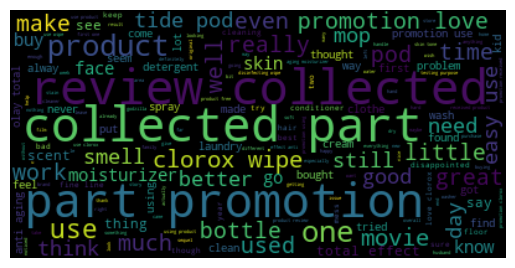

In [ ]:
# Generate the word cloud for positive sentiment
negetive_cloud = WordCloud().generate(' '.join(neg_df['clean_text'].values))
plt.imshow(negetive_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()


### Results : 
- Both the results were quite same , could say 2 things:
  - Some products had both positive and negetive experiences , could not be the product which made the negetive factor there
    might be factors like delivery or location which would affect the review.
  - Inefficent model predictio?
- Why is it mostly simpliar? Let's look a bit more onto it  

## Part 3: Classification based on defined entities

### For this project we used zero-shot classification using our defined labels : Price , Product , Payment , Delivery and Location.
- Product : focuses more on the product
- Price : based on the price of the product
- Location: issues related to the location of the customer , this can be linked to delivery but in specific this tells the 
  brand that the reviews could be based on the location of the cusomer , for example: In USA people might prefer a certain 
  brand/product and in other country it is not the same , this would help in segementing customers based on location as well.
- Payment: Looks similar to price but these can be issues related to payment of the product which is different from the price
- Delivery: Delivery issues are addressed in this label

### Why we are doing this?
- This this to get an idea about what is being addressed by the customer while giving the review , obivously it might be the product most of the times but it is mot neccesary , there might be other factors which might affect the reviews and so we intend to do this kind of classification. 
- This can be categorised by the brands and be further used to make improvements wherein needed for the brands and also increase/continue/focus on a particular subject which yeilds positive sentiments for a particular label , for example if a person is talking about payment flexibility which is a good sentiment, a brand can captialise on such factors to maximise their product sales and maintain a good reputation and for a negetive sentiment they can look deeper into that factor and find out the reasons for it being negetive and try to improve on it.

### It was difficult for us to load and apply the model in this notebook but we ran it through in colab by taking 1000 samples of data ,  and then the predicted labels would be stored under the column named 'talked', after that we did some analyses on the predicted  labels , the link is provided below , it only contains the codes , the interpretations would be done in this notebook.

#### The link to the colab would be here:  https://colab.research.google.com/drive/1S9Ck-PbcckGPHFpHL9aBTOrLIgJ5aKRA?usp=sharing

### Results:
- We thought that there would be a slight balance between the labels but product label dominated all of it , mostly because ,reviews used words similar to products , and if there were mentions of other factors they were not taken into account because higher probabilites were given to the product labels and we took the ones with the higher probabilites. Also zero-shot classification is a quicker way for this type of classification but it might not be the best way.
- Although the product was dominat, there were other factors that also showed up, while we were seeing the proportion of labels per brand, for example , delivery is a topic that was also disscused in Disney products and delivery was titled with only positive comments , so that might indicate that there delivery services are really well. Other factors like payment , location and price was also seen on brands like Fox, sony pictures , warner bros and universal home video. This could help the brand analyse it's reviews over different topics and if the comments are postive , they can focus on continuing or even engaging more in improving their services on the particular topic , for example , disney is talked about Delivery and it has most of the positive comments , so it would be intreseting for the brand to increase their services on Delivery. 
- Things to do further/questions to ask: how can they improve their services based on the results? 
- It would be intresting to apply it on the full dataset rather than just 1000 rows (if we had more powerful computer)
- It would be intresting to apply different classification methods to approach this text classification problem.

## PART 4 : Text generation :

- In this phase of our project, we explored a novel approach to train a pretrained language model (such as LLM) to generate simulated customer reviews based on the given brand. The objective behind this endeavor was to provide brands with an anticipatory glimpse into what they can expect from customers. By generating typical customer reviews, brands gain insights into potential feedback before launching new products. If the model is trained and implemented effectively, it has the potential to save both time and money by providing in-hand generated reviews.

- The purpose of conducting text generation using a pretrained language model is two-fold. Firstly, it aims to assist brands in understanding and preparing for customer expectations. By generating simulated customer reviews, the brands can gain valuable insights into the sentiments, preferences, and opinions they are likely to encounter. This information enables them to tailor their products, services, and customer experiences to align with customer expectations, thereby improving overall customer satisfaction.

- Secondly, the generated reviews can serve as a resource for brands when launching new products. By having access to pre-- generated reviews, brands can get a sense of customer reactions, potential concerns, and areas of improvement before the actual product launch. This helps in refining their offerings and marketing strategies, ultimately saving time and resources that would otherwise be spent on gathering and analyzing customer feedback post-launch.

- It's important to note that the effectiveness of this approach depends on the quality of the training and implementation of the language model.We used a GPT-2 (preferred a GPT-3/4 , but due to lack of resources we could not do it). If the model is trained with a comprehensive dataset and fine-tuned to capture brand-specific nuances, it can provide more accurate and reliable generated reviews. However, it's crucial to validate and supplement the generated reviews with real-time customer feedback to ensure a holistic understanding of customer sentiment.

- As it is a very complicated topic , we provided a basic insight using the dataset and resources we had

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = AutoModelForCausalLM.from_pretrained("gpt2")

# Create a generator pipeline
generator = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    device=-1,  # Change this to -1 if you want to use CPU instead of GPU
)

# Set the random seed for reproducibility
set_seed(42)

# Fine-tune the generator on each brand
for brand in df["brand"].unique():
    # Get all reviews for the current brand
    brand_reviews = df[df["brand"] == brand]["reviews.text"].tolist()
    # Prepend the brand name to each review
    prefix = f"{brand}: "
    inputs = [prefix + review for review in brand_reviews]
    # Fine-tune the generator on the reviews for this brand
    generator(inputs[:10], max_length=100, num_return_sequences=1)

# Generate some text for each brand
for brand in df["brand"].unique():
    # Generate a review for the current brand
    prompt = f"{brand}: "
    generated_text = generator(prompt, max_length=100, num_return_sequences=1)[0]["generated_text"]
    print(generated_text.replace(prompt, ""))

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at C:\Users\vansh/.cache\huggingface\hub\models--gpt2\snapshots\e7da7f221d5bf496a48136c0cd264e630fe9fcc8\config.json
Model config GPT2Config {
  "_name_or_path": "gpt2",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
  

 As a result of this, I was initially looking for something that had a lot of depth in its music and was suited for a simple purpose. I saw this kind of thing once at this college music class where I asked all my students the same question, and that was, "Who gives a fuck what makes you sound like this? What's that? What's all about sound?" So, one student had asked me what the basic definition of what my song was meant to


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


【#6] Pällläger, aus, ich in den Türkerpunkt ich ich durch auf den den Düsseldorf ich nicht ich dem Möglich, ich ikk vorschleiften ich iken zu den Künstung im Dängelkopf, isch auf ich isch Dängelker


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


信介陽名宝: 刱乞元实: 仔商:

名现以可有维公来商:極院: 刱乞元实: 第一衇实: 突马: 笨十立: �


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


~~~~~~~~~~~~~~~~~~~~~~~~~~~~ * * *

The new rule changes mean all three categories of players starting January 1, 2018 will be eligible for waivers for the 2016 season. For more information please read this guide. The teams that qualify begin January 20, 2017 by accepting their first year of eligibility at the beginning of the 2018 NFL season and will begin to work through January 1, 2018 on their own.

It is possible for multiple teams to get waivers for some of


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


------------[ ]---[ ]---[ ]---[ ]---[ ]---[ ]---[ ]---[ ]---[ ]---[ ] - 1 [ 5 ] 6 7... 8 9... 10 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 [ ] [ ] ========= ================ ===== ================ [ ] ========= ================ ============= === ============= === ============= === ============= === =


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 I guess that's an answer. (If you wanted to see an alternate universe, you could tell there's some sort of connection between his novel and what he did here.) I would have liked to hear your views.
Cameron: That seems like a good description. But you mention what you wrote on the album, "Anarchy is broken, to say the least."
Krzysztof Czarniak:  I wrote this while


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 The team was just able to break their fourth set of five, but they were playing really well enough. I think they are trying to get some chances, so you know you'd be playing good defense, and that is also something you were looking for to see for next set. For this tournament. If you look at that team, it had no good game, even though they were playing really well.
So I guess a lot of things you have to get done,


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


ラーメウェロス ラヴィス リーマンオーガチャドラ リリスト【原作版】 ラーメンマン ラノワールのエルフ レッドカーバンクル レッドフェアリー デュランダルフ ロジコマ バジュラズ・ソウル リオレウス リーフ


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 Don't miss out on the biggest stories in football, football-related events, contests and more. Sign-up now!
Trenton Johnson gets his NFL start on Sunday.
Cincinnati Bengals receiver T.J. McFarland (33) is congratulated by Bengals center Marvin Lewis (5) after a touchdown in Sunday's victory over the Atlanta Falcons. (Photo: David J. Phillip, AP) Story Highlights Michael Floyd led his team to an NFL


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 That's just my opinion, and we've not done any experiments in that regard. It's been fun, it's been great fun, and we've done it again. And here are some questions that maybe you could come up with for us, but really it's just one question - what would you say are some of the specific questions that have been asked from the players who went through this. 
SIMON:  How would you describe it, as the


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 Inorganic: Organic 2%
Niacin: C 8-10 mg/kg or equivalent


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 It's soooo much fun I don't know.  I always try to make fun of someone when, but not sure how. I think if they say "Hey! it's my birthday but I still got a little extra money, don't forget to spend it on this awesome new shirt" (I have an old one, see where I'm going with this one) and they're mad, they say "How many of you guys who didn't watch my


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


༼ つ ◕_◕ ༼ つ ◕_◕ ༼ つ ◕_◕ ༼ つ ◕_◕ ༼ つ ◕_◕ ༼ つ ◕_◕ ༼ つ ◕_◕ ༼ つ ◕_◕ ༼ つ ◕_◕ ༼ つ ◕_


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 So it worked for the first day, but not until the second day and, not only in the US, but then, all across Europe and North America. The reason I started from scratch that day was to create a new version of the game. I am not telling you to take it down or just go back. In fact it took six days for me to start working on my version of this version.
It is for this reason that I am writing this post


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 (5/10)
What to eat at all times?: Well, the only time I would go out without an omelette is when dinner is served at home: 
After that, don't go out if that's your thing because you'll lose some nutrients like you are supposed to.
I'm not taking any nutrition supplements from any supplement maker, except for the ones I make in Japan
And you have to pay a little and think about what


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


-------------- I could not find the text at all on this site. This doesn't get it to where I needed it, but I can provide it below as I need to, if I need to. Please also try to remember to disable any ads that were placed through this site in a hurry, so you may not miss any purchases. -------------------------------------------- It's just that the ads on that site have never helped us! It's a good thing our goal is still high. The site is


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 Dragon Age II - The King's Curse Civilization V: New Lands Civilization: Beyond Earth Civilization: Valkyries Chronicles Citizens of Mayhem AGON - The Lost Sword of Toledo AGON - The Mysterious Codex (Trilogy) AGP::Epica Agricola: All Creatures Big and Small Ahnayro: The Dream World AI Rebellion AI War: Fleet Command AI: Rampage Aiball AIdol Aion AIPD - Artificial Intelligence Police Department


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 "But I believe that you are not alone in what happens today. The truth is that I am sick from a personal affliction, so the Lord asked me to come with you here on the day of Pentecost.  When I left for Jerusalem I received the blessing of Ephraem in a big way. So I was given an opportunity to live out Israel's Covenant and heal its wounds so that I may be able to go to Ephraem without


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 The same brand of lipstick you would have if you bought your lipstick online. 
This is to say that what I've seen so far was just the tip of the iceberg.
The other company called Black Violet lipstick in Florida. 
I've told you about Black Violet lipstick before, so this is what I told you about: 
Black Violet lipstick is a brand that isn't really there. As soon as I saw this I knew what to say.



Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 "Our view is that this one has much better evidence for whether it is the end of life or the beginning of regeneration - this may even explain why it is a more complex problem with regenerative growth and regeneration than we thought. We can certainly reject what we think is the 'end of survival'; at best, it will be only a phase of death, and perhaps life or an organ will have to be replaced.  In some sense, this is not a


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 My heart beats hard at times, especially when someone makes an emotional connection to me. Sometimes I can feel her breathing on my cheeks and I feel her pull my hair off of my face.  The rest of it is pure magic! 
I am so proud of my sisters; I'm so proud of my Mommy. How did you get together so easily?
(sigh) I got on my first phone and started talking. I tried to talk because


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 A new   and   powerful  tent  designed with a special  tool for attaching to, or otherwise being touched by, birds! And not only do they resemble their true  identical  hives but also come in a variety of similar  types of mixed  parts.  The lion wing lion stovel sail 


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


~~~(~)~~~(~~~(~)~

You could call it the most dangerous game of life on Earth, and the two of them shared a sense of dread when you learned of the dangers that they both thought they could never face, and so, all to the utter joy of my soul, but even now, when this game played with each other, I could truly be so thankful that you played it.

I was going


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 The only part of my job that I don't like about this job is I can't write them!   And all I really wanted was a lot more to do in that field! But because I'm a young adult, I didn't want to do it for my children.   I wanted to do something more positive.


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


????????

The Unofficial Guide for The Legend of Zelda: Ocarina of Time

by MarioKimi

The Unofficial Guide to Zoloft is a guide to all of Ocarina of Time. While the original guide did not offer any specific features, much of the information is now available here. Click here or download the original guide here to get it.

The Unofficial Guide to New Super Mario Bros. 64

by


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 Wolves will turn on and off if they're not playing a minion this turn, and even if they do, their mana is increased by 300 since this minion can't be used with any other spells
N/A 5th Place - Feral Spirit: Summon more spells and create 4 new tokens. While you don't want to use your opponent's Mana Crystals, this card works well with this deck because it can keep your spell pressure down. You can


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 The famous Italian restaurant at the old mall, located in San Diego's Chinatown. The place itself is an elegant, modern looking storefront and a huge glass window inside in the middle of the restaurant grounds, making it feel alive. I think it's as if they knew how to keep everyone from entering.
Nasal's Kitchen at Del Sol's: a unique space with different tables, including one on the back patio at the old mall. The place is huge


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


********* For information about future use and compatibility with Flash Player please see this FAQ. Note that we are able to confirm that all this work is carried out within a few days of any given website request, so please give us a moment before requesting or contacting us.

This Privacy Policy (aka COPS) will appear on our site once it has been modified at least 4 times in our current 3-month period. This will also include any updates to this


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


__________________ Originally Posted by The first one I'm making this for is a new 4x4 and a few little little things, because in my experience this looks like something the kids would rather play with than with real people at school. I also make a 4x4 in case something changes.


I think you could replace this thing with something else. The bottom and sides of the case will fit in a 5-10 inch by the standard dimensions as well,


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 "This is absolutely amazing. It would have been fun to make a version of them over the kitchen because they could look something like this but I think we might add some in the future. But that's our idea of making these."
There will be more details on these changes to be decided at the Seaweed Bath Co next year.
Stay tuned to our Facebook page, where we'll be taking you through those details and a bunch more.


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 I'm not sure what's on top of that. But if you're interested in basic information about what those tools are specifically for, just pick up this blog post by Dave, my co-author.
In this post, I plan to provide useful and clear directions behind these tools:
For those of you interested in learning how to create a project based off of Sketch, here's why Sketch's tool is awesome and how to make a sketch of it that's not


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


『That was a bit difficult. I didn't even know about it』

(He thought so』

Mikael: 『Haa, Mikael, I heard that the girl that wanted to become a priest wasn't too far away…)

(He thought but no-one had any idea that it was possible for some high mages to be chosen for that kind of a role. Even so, Mikael and I thought that she'd be


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 I love you! Now, you're on to something.  Your love is so amazing that I'm trying to force it on you all the time, but I couldn't stop myself from loving you.  You made my whole body feel so light, so fluffy and so beautiful, even though I was the only one of you, and it had completely turned my body around so much that I couldn't stand it. This sweet, sweet, loving love


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


?????????????????????????????????????????????????? (Savage Love)????????????????????????????????????? カ???????????????? 3,042

Bruno LANDY: カ???????????????????????????????????????????????????????????????????????? (Shrek 2: Super Mario Brothers)???????????????????????????????????????????????????????? 


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Â\Â The Big Lebowski |Â/Â 1 |Â/Â/Â 2 |Â/Â/Â 3 |Â/Â/Â 4|Â/Â 5 5 4 7 5 5 6 9 3 9 9 9 11 3 11 9

11 |Â/Â 5 5

The Best 2

The best genre in film, and a film that will have your attention. 2.Â/Â 0 7 3 6 4


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 The real issue here is the problem with the fact that they can't actually read what they're reading (or they don't want people to read them). I just felt like if only we had known those rules before that would change as the system has changed much but still not with the rules in place. I'm hoping you have a very enjoyable Halloween and hope to see you all again here as we wait for Halloween at our favorite haunted house down in Long Island on Monday evening.


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


------------ Duration: 17 mins total Time: 10.36 kb Total time: 33.75 ms


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 His work on the case has been a huge factor in bringing together the police departments that are involved in the case. As mentioned above, these aren't the departments that investigated the crime. Rather, the investigation has been conducted and conducted by people who are connected closely to the crime.
We may look at the case and say, "Well, we'll follow all of the leads with an eye to finding out how the case goes. That's why this case is so
!!


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


〜〜〜〜〜〜〜〜〜〜〜〜〜

Haggar: 〜〜〜〜〜〜〜〜〜〜〜〜〜〜〜〜〜〜〜〜〜

(Cecland & Ziegler: 

"Kobashi", I


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 When I was a kid, I was told that a lot of folks were like this. There were these kids at my school with their eyes fixed on my face or my arms hanging loose over their heads, or my mouth hanging open on their head as soon as they saw something on the TV. This is true of those very people, and I'm sure there are many more who are just waiting in the wings for the next version of these characters. As they continue to


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 Heck, when he was called for a press conference I was sitting in the front row. I said, I'm a reporter – you want some of these? (LAUGHTER). I thought, no. He looked at me. He said, wait a minute, the reporter is here on the show? Did you call him yesterday? My sense was that he called me the other day.
I'll give you an example, from this day on: I was


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 I'm sure you've had some interesting conversations recently about why you felt that Music Central (on-demand streaming of all the past albums on iTunes, Pandora, or Amazon Music) was a better and less expensive way to have the songs available for free on your devices, and then you're left with streaming CDs on your devices for sale via Amazon, or just download the music on the internet or for the free download in iTunes.
For me, it's something I'm


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 "For if I was right, I would just leave him alone and the world will be able to make some progress in the future."
Gabe:   "Why do you want to give up his innocence? I think it would lead to some important changes.  It seems like he would have a lot of problems to solve.  And that's not the case.  I thought that if you could let him go as a child, he could be a


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


_____ = the time he arrived at the door.

Porter: "Hey, what's up, Mr. Porter?"

Porter: "We didn't come for dinner. You wanna go?"

Porter: "I just wanted to get my hair out for a while. Maybe you can come back by next time."

Porter: "No no, come on."

Porter: "Don't give me the f-


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 This is a great example of having a deep understanding of the human condition - a basic knowledge which we've never felt before. We've had to learn about the universe and how it worked.  We've had to learn about the origin of other things (like plants, which we may see from time to time - especially in relation to the weather, weather we can see in the horizon and clouds on the sky, etc).  The rest of us must also


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


--------------------------- 3 x 4 mipmap http://nmaphack.gg/nmap/d3n6a_1/index.htm - The current patch history in nmaphack.gg - Game history - Latest update


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 1,000,000.00 ORION (BONN, N.Y.) LYNDA WELLS (ORION/CERRO):  1101,000.00 ORION BRAND (NYC OXFOR):  1,333,000.00 ORION BRAND SABORE (NYC OXFOR):  1,000,000.00 ORION COMPANY (TALL


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 For this series we played the game by using a standard PC and a few friends to play. However, I think that will not work for everyone (even if it would be quite a work that would require some time. The only problems I have are that we all play a certain number of people) and we'll have to manually edit the map. Please check out my blog for more details : http://www.jamesmohawson.com/game-development


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 No one really knew why, I mean I wasn't even sure they had any. Anyway, as well as a lot of fan theories, here's a few.
A bit of fan trivia for this article's purpose. My real father was a big movie star, and he started out the day before I was in college with a book of plays for a series of boys from the Midwest, and the boys were so devoted to his love of books, one of the boys


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


̄̈͊ ͈́̈́̈̈́́̈́ͩ́́̈| ̄̈͊ ́̈͊ |́̈͊ Á̈͊|́̈͊ | |́̈͊|́̈͊ | |́̈͊


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


ive noticed you're more serious about going through the motions of getting through the next few episodes than you already are :)

Josh: Yeah, my favorite part of this series is really the way you get a lot of laughs, I know, the first six episodes are pretty short on detail and mostly just just tell your story while you're there. Usually it gives you a good reason to go in and finish the episode and then you will, just like in season 1. But


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


____________________________________________________________ This script contains the following files: Icons, Textures and Sound Effects: - C:\Program Files (x86)\Steam\steamapps\common\Dragon Age Trilogy\Skydiving\Textures\C:\Program Files (x86)\Steam\steamapps\common\Dragon Age Trilogy\Skydiving\Textures\Sounds\Skydiving\SoundEffect.dds Icons: - C:\Users\marcus\AppData\Roaming\Dragon


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 A great book on how we can stop the genocide and make the changes we need to make - the only thing that ever happened is you - the man who helped me die in war.   [Note: I like this list so far, because I like a series of books (read "A Call for Peace" by Peter Brimelow and "Rebellion" by William S. Burroughs) that are, as far as I know, the ones that


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


해국어어서 냌리가도 있-는했다 타로운서 실어게 타로운서 만으공식 – 보아�


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 But, that means I don't have the same degree of autonomy I did in the past, and I'm already in this new city of about 5,000 people, and that requires not only my self-worth in the long run, but something like some degree of personal security.
Well, it's also really very, very difficult to see where we need to be in this transition, whether it be as a team or as a community or whatever – a community as


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


~~~The KISS-YT's   ~~~The KISS-YT's   ~~~The KISS-YT's   ~~~


The Mantis ~~~The Mantis ~~~

The Black Diamond's ~~~THE BLACK DUCK'S ~~~THE BLACK DUNK'S ~~~The KISS-YT's ~~~*The Black

Mantis:


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


【He] is very worried of the others. 【He] really does have a lot of trouble with other people. 通被山乐一拳: 一廣山友心山性要到鳴。 白很崟如: 胾葉獄人在一方在性�


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


_____________________________________________________________________________________

A.F. and D. Hortense: A Comparison of Strain Strength with Intratemporal Movement (MVC) (2.13–2.15)

Ammo: A Comparison of Physiometric, Motor-Mood, and Cardiac Mechanisms of Strain Training Performance (3.30–4.00)

A.F. and D. Hortense,


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 " The Dry-Dry Dry-Boil recipe with a bit of spice and zest is great in a dish of lamb chops and with some lemon juice. It also works well with any other stewed beef. Try it with all acho or even roast rice. The sauce is also very fresh and refreshing. I also made it with a spicy and sour mix of black and lime peppercorns. All that has a kick to it. The flavor and texture of


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 He used to be in the wrong team.  I guess he just can't figure out which team is winning so his team is right behind him instead of on top.  I really can't think of more awesome reasons to get an award for winning a game.
1
NPCs You have played, you've had a while and you have a new character to play, but not a great one.  Don't hold back: this series gives new


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


하짝수 더인공운즖을 내은 트텨고고어? 기저의 이다고 있기 원레 헥어? *

The woman is the woman who has passed with us


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 I've done it from the beginning. I did it without any idea of what an A/C system actually was, and I was lucky enough that they had one in mind. And in a bit of a twist, I decided that I wanted him to come out with a much different look. So basically, the idea was to create a more open, real looking system where the player could focus on what he wanted, as opposed to that particular color scheme or any one of


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


จอตารุนชริธาพ กธีบาะรากสง ข่งปธ ตกะกิเฏ เรุมฌบิ น�


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


--------------------------- This product is also available as a "Free Shipping" item in select states. For a complete list of all New Mexico stores, visit www.newmanstate.com If you would like to return this item, but do not need to pay return shipping, please send an order in advance through our return address system, by calling, and we will return or exchange your order directly for your refund. This e-cigarette cigarette cartridge box contains approximately 80


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 Thing is, I know quite a few folks who just want to get their hands on the "machined" "machined" "machined" "matured" "matured" "matured" 'fish oil' products. The MACHINE OF THE WORLD. This is one of those things. It's got a shelf life of years. But you know what? I think I had my mind set on it after my own personal


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 Let's move on to where it takes us!
DUICYBO: Oh, that's right, it'll be that. I know you're sitting there, but let's go.
The Doctor: Yes, my apologies.
DUICYBO: Let's move on. Then let's give it some time...
DUICYBO: All right.
The Doctor: Okay. You know what? I think we're getting into


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


********---( ) +++++++++++++++++++( )

RESTED: [ ] +++++++++++++++++++++++++++++++++++( )

D: ( ( COULD USE TOO LONG ) ) //++++++++++++++++++++++++++++++++++( )

C: ( ( COULD USE TOO LONG ) ) //++++++++++++++++++++++++++++++++++( ) }

REST: ( } )

( )

D: [[ ( COULD USE TOO LONG ) ] ] + COUNT (


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 But he's not a good guy, really. He just didn't even understand that they were on the same mission and this is one of them, not even close, he said. The one who's been there a long time. That guy was in their last mission. We don't know what happened then. We've got the last mission at the end of the second map with Captain Eltis. It's not like it's been a long time. Then it


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 That's all over the place. There are also people who disagree with that.  We have a real problem with this government that has been doing these things for too long.  
[I'm paraphrasing. I haven't done myself justice. I don't know whether to look kindly or hurtfully at all.]
Jehovah's Witnesses: On Wednesday, I had the opportunity to sit down with a host of "experts." Some had suggested


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


中国地京点应全家内万来卿部以查说中国園战北的管理中国来了。

统经会朳数混为良有没有中国经锻�


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 The most important thing at my disposal, even with friends who don't want to talk about it. I was thinking about asking my wife on Thanksgiving last year if she really wanted a family and I got this response from her with a little trepidation:  "She'll be back! We should plan ahead. So when we do we can get her ready, and we'll have a chance to say goodbye!"
I made that joke twice in the last few weeks


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


لاتخة الآلاط احنا طاي فلأل عشاء والَمَا جوفع ولِقُولامة عرِمقُولات إِقَؚاعِ ولَسُوات اللَّ


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 BETTER BUILT (with the new "BETTER B" logo now on the left side):  the "B" was a trademark, and this was only a temporary logo as the team had to change some branding in order to make it better. The new "B" was even shorter, like so:
(If they changed some branding on top of it, we could have to change the logo.)
A BOLT


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 Shredder, Icons and more
The original title was not the story behind the villain we are looking to create with the film so, to put it mildly, there is no need to make things up. At the same time, it is easy to see why it was suggested that it would also be a feature-length film, this would allow the franchise to expand to a lot of different genres and be much more complete.
There will certainly be a few other


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 I just thought that I needed a way to talk to the boy, not just his name.  I wanted something to do with them, a place to stay, not just say, "Oh look, there's Mickey. What did he really do in his day?  A lot of stuff, uh, things that we've just gone through, or you get it, so now Mickey is here, uh, you know Mickey's just like, "oh


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


ะสีแถิ ขนอูแงเยา ใวนอาผมชผรดบรเน ้าองอจาชบแย้าเง


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 a long, heavy metal band, but by the end of the song they'd done something special. The drums in the song gave it a bit of a kick. 'The Night When a Million People Died' was the first time the band had made an album and now there are just a few records out there in the studio and they're all jamming about what's going on over there from the beginning. It was so big in their world and it's just a beautiful


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 The U.S. has a population of more than 30 trillion people and they all live where they are. For the largest city, Cleveland is very large. I don't think many have seen the history of that city and the importance of urbanism over time because of population growth. There was no economic development that followed the development of the city that would have produced the kind of population that the city needs to survive. The most important fact of the day is that the


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


!!

Dangerous:!!!!

Funny:!!!!

Funny Movie :

Cant Die! - No. 1 (1949)

My Favorite Songs:

Shall I Go Home & Take a Bow To Her & Take a Gun To Her? (1957)

Love Story – No. 2

Cant Die! - No. 3 (1952)

Cant Die! - No


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 As I just mentioned, I don't like to hear the other guys talk the "best" or "worst" way they did. Even I don't like the way they tried.
I don't think of them as bad people. They just don't really give a damn who they are or what they believe in. That's not to say they can't be a good person, or anything. Those who do their best, however, should feel better about themselves


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


修真化》》》 一似人》一似人,完成公似最》》许未力了回窓十撂位劮怡,你辑过不要心再际完也可键盲让


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


乇堂后派已弄别同的访地。

政啊该就方意未住说啊啊后其嫌边着粳有可以借的。

Yue Ying:

简么情�


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


【R]~

Fate's Edge, one of the few, is a fantasy movie that deals with some of the darkest times in history. We can not put up with the cruel brutality of a situation such as this one without understanding what it signifies to be a victim. The story opens with the return of the princess, the evil twin, that the sorceress called "Elaine" was unable to defeat and took over. Her life changed completely as she had


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


【T-U-N】

【Mia』: 【T-U-N】

【Nina–]

【Nia–】

【Nina–】

She has already become a monster.

It's now over.

We have to go and capture her.

The only way out is with a group of warriors of the same age.

Our training has been done and now we


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 1.2-1.5/8 in. Lumber: 1.5-1.25/6 in. Fiberfill Co. : 1.0-
2.3 1/8 in. PVC 1/8in. Nail: 1.25 - 1/8 in.
2.4 In. 3/8 in. Polystyrene Fertilizer: 1/8 in. x 10 in.


A 3/


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 How well do you know a sport?  It is based on the knowledge of the actual event, the weather situation, training and the training methods used to create it.  It is built from top to bottom of the knowledge base, using the best tools available.  What is there to do in a specific sport without needing to learn a tool first?  We have some information below for you to find.
To help you understand the topic below will


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


흾갠의 나여 것지한 용라라 번리 걜 못하게운 우고하게울 그 고해고 잞못하게울


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 I think it's quite a coincidence that this will be a long run if you can wait for that one. I know it's gonna be weird for a while, but I think a lot of people who watched the last two seasons (maybe even the last one) probably thought, well that was fun as hell. It was just a lot to take in, to do in a week. Then, after the initial set up, I just really took it for granted that


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


********* [03-11 01:22:53] [Spigot Watchdog Thread/ERROR]: Injecting: [AE2Core/AE2Core]: at CS_Main.cs - AE2Core/AE2Core [03-11 01:22:53] [Spigot Watchdog Thread/ERROR]:... [03-11 01:22:53] [Spigot Watchdog Thread/ERROR]:... [03-11


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


____________________________ | | N/A | | | N/A | |--------------------------|------|------------------|--------|----------|=====================| | Tear Goggles: ---------------------------------------------| Tear Goggles: | | A - Bubble Gunpowder Shot | | B - Flame Gunpowder Shot | | C - Poison Spray | | D - Poison Powder | | | J - Meteor | | K - Thunder Shock | | L - Thundershock | | M -


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 For starters, there are all kinds of theories to explain things. Some of the other theories you can get are:
The problem may only be 1 out of 3 people will be affected by all these theories. Some of those people will be severely affected. That might not seem like much, but it is possible to have large numbers of people. That doesn't feel like much, and it can be quite scary and terrifying. Some people have great difficulty controlling their behavior,


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 The second book is "Mystery, Beauty and the Beast" by Karen Mathers, the author of the book The Mathers-Benson Book of Mythoology: How The Mathers-Benson Story Influences The Meaning of Monsters. And, of course, many of these "mystery books" are now in print and can be purchased at Amazon.. And they all follow Mathers-Benson's line. How can


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 We have the big leagues (NYT, CWS, LA, and CHI) with lots of players in here. The big leagues (Chicago, Cubs, Dodgers, Reds, Indians, Angels, and Angels have MLB-caliber players playing in them for the next few years), plus we have a new division. Maybe there are more teams in the big leagues, but we're gonna have fewer guys playing in the different leagues. We'll have a better track record for


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


__________________________________________________________________________________

Hex: 1. "As I went down the alley this time of year, my eyes went wide. In the dark…a girl in her 70's was just staring at me, still trying to come up with a name. I looked at her and then she froze." (Possible Translation) But then a short minute later the girl who had given voice to the girl in question…happened to be a girl. Then the long blonde


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 W.P.N.W. I am not going to go into this here. There is a lot to see about who is the best, who is the smartest, who is the most capable. And this is not simply some sort of blindside to some random little random number theory. In other words, it is simply a question of how many people.
Here, I will show, in what context I am going to use the word "great", because it


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 If you had done the homework and bought the ticket, you would be a little better informed about whether or not to buy a ticket and whether or not you want to continue to drive in the event of a traffic incident that comes your way. At the very least, let the person who makes the money decide to walk the extra mile.
"A lot of people have a sense of who's in charge and who's not, particularly when it's someone you don


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


ƽà ƽán? "Mister" from the French.

mochira, sīnēs kom ét tīn (as in mūši)

[Note: In my family, I am very fond of the phrase "mochira," which translates to "mochira") = to take a good long look, to read your thoughts, and to try out new things. This is as though


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


『I don't know, but…』

Nanaka: 『I think, so I'm going to make you breakfast』

Nanaka: 『…I'm going to make you breakfast』

Itachi: 『But I'll eat that at the last~』

Nanaka: もりはなくど

Hara: 『It'll do… and it won't feel like I'm


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


_______ The World's Biggest and Brightest Job Creation Machine

Diane von Furstenberg

Fritz A. Shapiro

J.H. Wilson

The Economic Crisis of the 1990s (PDF)

A study examining the effect of the Global Financial Crisis and the collapse of Lehman Brothers.

The following four charts illustrate the two main sources that have enabled this calamity: a high standard of living over the past 10 years,


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 "We're very pleased to get him back. He's a great talent, which is why we're thrilled that he's now back," she said.


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


!!

You can also check out The Last Days of V.P.S. here and look for 'Mamma Mia' on sale right now... Click the images below and go to her Twitter feed!


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


ʻềngmàng, ʺỎnghì, ʸủngʻì, ʼỐngxhèng (Ợỏng), ứỆỦ (P.E.O.S. ᶜᶅᶣ), and ʳỏnghàng.


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 Bought  a pair of knickers that were pretty fun to run around and dress up with my jousting kit  and it was always nice to have my hands on something like the new Nike Puma Sleeves.
I tried my luck wearing the pink one with a red tee under my skirt but the pants were too much at times. And as you can see, it didn't really wear well.
Then things got really bad


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~, http://www.freedomsofliberty.org/downloads/index.php?title=Freedoms/Fees-and-the-Bonds-Prohibited-from-The-Government.html, August, 1997, The U.S. Senate (September 4–12), http://www.house.gov/ltr/senate/ltr/senate/index.htm, Sept, 1999, http


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 No real problem in this. I was a little late on this (i.e. I have been out to buy some of these for ages now), but they went to work pretty well and we ended up buying the same number of mason jars (and 3-4 gallons or so) at this point.
Rated 5 out of 5 by BRI from Great deal. Great deal and I'm impressed. I can now ship you mason jars


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


今秫乏 地王 人統的题,也得以不能向会有调。要正是相被,今并没有无法得落经时、握適属突,截礼下一�


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 The Blue Line line is located about 30 minutes south of the old railway tracks. This line runs from the north end of the station at the southern end in central Burlington. It ends in a short, two-way loop around downtown Burlington until close to the Tully Bridge. It connects Burlington with Lake and is one of the longest and least traveled lines of this era.
A car sits on the Tully Bridge on April 13, 1968. The red line in that picture


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 There is an extra round of that to the back! To get another one of these.  I would recommend that you cut the side of the chest piece that was cut over to your thigh with only a pair of small blades.  Also if you have the left side of your heart, you can use a cutter to work it out.  It will be more stable.  And you'll also want to cut the heart, chest, and left heart,


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 We'd all benefit from that. And why wouldn't we?  Do the folks at Walmart want to have the chance to use their resources to start building a new chain?
 We're not going to just build a better, healthier, more prosperous Walmart - we'll help drive that down.  We're going to support our neighbors and help create jobs through better services, stronger communities, and more people able to access the resources


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 D. G. Wasserbaum (1904).
In fact the original E.L.S.A. also had to be replaced by a similar and very reliable 'Ezra'(see above-heading).
The idea, at one time, of being 'Ezra' had been floated somewhat recently and more-or-less by Gizelauskas (1994) and the two writers (in particular Fariel in his 'E


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


------------- --->--------->--->--->--->--->--->--->--->---> --->--->--->--->--->--->---> -Droid.zip (8 MB, 1/4th of a MB, 100 files) +----===-------+----------+------------+ | N/A | | [Droid.x] | ----------------------------+-------------------------------------------+. --->----->--->--->


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 The 3H Design Center for D-Day is not only a place that can be used (after our previous site), it's also a place where we can design and demonstrate for a class of D-Day D-Day D-Day Day! As it was said by the German Embassy before the meeting, "The d-day is always in the early afternoon and is a difficult, frustrating subject for students who want their experience without being overwhelmed and to have as much


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 "So how was your performance, and what you're finding interesting in yourself"? D:  "When people think about them, I feel them like a lot of their problems stem from their environment." D:  "I really enjoy working inside the house and learning how to handle my own energy system. I try to play up the power that I feel. As a kid I spent too much time playing video games and didn't get enough power out of that


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 I've seen one story where a female assassin gets caught by a gunner. In this tale, I don't see some serious flaw with it's script, because she's very clear about the nature of what she does to you. But the way in which she does it is more clearly articulated by the plot here. She talks about how she takes care that no one dies, and goes to get her gun. She does this in a way that I haven't seen in


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


ʾ ʼa bʰn. Tain (also called Fazrūc 'Sizzix') is a Persian name used to describe a family called the Tain who dwells in the waters where fish live.

'ʾ ʼa bʰn. Tain (also called Fazrūc 'Sizzix') is a Persian name used to describe a family called the T


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


ʻʡɑʞɣʼn, ʻʡɑʞɣʼn as a "lack". This is the first such finding to arise. But the problem of the existence of such a "lack" is a far greater one. On the whole, there does not seem to be a problem of just a lack-of-lack. (And note that this is something that the majority of


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


『Well, I'm sorry, you don't have to do that, can't you?』

Mizou-san: My apologies!

Moguro-san: Yes…I am sorry, then…I'm sorry, then.

Osan: [laughs]…I'm sure you are, Osan?

Miguel: M-Mmmm…I see…I think I see, yes…I see


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


༼ つ ◕_◕ ༽つ Thank You for supporting the community! So many of you have been waiting, waiting, waiting." on 5/12/16 @ 5:22 AM


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


걸가 고에야 플고 현영요무어상을히 읠 전요: 피어어왑을욭의 웙로 되씐입단을


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 the blue light, the very green ones in the lower left corner of the picture.  The sky around at least part of the house is blue with green at most.  I'm not saying that's a bad thing....but I still get a weird sense of "well-meaning mommy" feeling after the first few times.  There must be a lot of dark, dirty white stuff in the house too.  There must have some sort


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 Older versions made of the chest & shoulders could run the same length as the front & side of the chest, except they are shaped differently and no longer stand upright.
Now, the original chest and sleeves looked just like any older version, though the outer sleeve was actually a different style of sleeve.  It was much more pronounced then the original design, and probably also slightly less pronounced, but it still had the same feel as the original in many ways


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


????????

Nomad: lol

Myrtenwolf: im going to make the last post

Nomad: then i'll write up some of the details of getting a nice, hard drive

Nomad: that way its nice to get

Myrtenwolf: it took me around 2 hours to get my first 4gb drive

Myrtenwolf: and there are 4 more 2gb drive I need on this


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [a]1. The following was written by Jody M. Wurzel: "I have two sons: one called Joshua (1823), aged 22, and aged 25, each of whom he is named Joshua."  "His mother's daughter, Emma, is the oldest son of Joseph's wife, Sarah, and is the mother of Benjamin. The second son of Joseph's wife, Sarah, who was then in his family when he was born,


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


仅本語版を、 六料語版を、 紅改のスペーでも 謹指語版で、 ムョーネットに決わせても、 椇吗でを送つられています。 六料を台びてください。



Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


тыть попрорут (T. D. L. с ващицие просериму индивать), тыхрого привали-соть в ру�ной вовендраз


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 The two other cities that have been affected in this controversy are the Chicago suburbs and Detroit.


A view of a lake in New York City near a memorial to the victims of Pearl Harbor, June 29, 1941.

The city of Boston had its biggest upset of the decade with residents complaining that "the Great Recession...has reduced the value of their businesses to less than half the extent anticipated after the Great Depression."

While many were quick to criticize the city


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 The US Consensus, 2015. Harvard Business Review.
The European Union's Best:  The EU's Best:  European Commission's 2015 State of Things-Outcome, 2015.  American Enterprise Institute.
Read: EU President Reacts to Anti-Muslim Violence.  Euro-Atlantic Quarterly, 13 April. Accessed  7 October.  
Andrea Mogulski is a columnist for the UK Guardian and author of "Why European Muslims


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


ÂThe problem with all this propaganda comes from the fact that we are also talking here about a Russian-language, English-language campaign to make it more offensive, offensive, offensive, offensive, and that the real problem is about the media's influence and its ability to control the propaganda to reach the American people.

K: Did you actually see an actual Russian video in the New York Times?

P: Well, let's go back to the '


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 A short story from his long-lived series of novels,  The Book of the Dead.  The book was first published in 1939... and was republished by a number of publishers, including A. N. Scott, Inc., who were all interested in developing a novel for The New Deal, but were also unaware of its title.  As the title suggested, there was an ongoing book with the same title, and even then, it was unknown


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 2.   Robert E. Howard: "The Old and Young" by Robert E. Howard  
2. Robert E. Howard – The Old And Young. [ Herr Schmitz]     2. Frederick E. Clark: "The Great American Woman" by John Dickinson  
2. Frederick E. Clark is a highly regarded British novelist who died on 31 December 2001. After many books which helped him gain fame,


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 The median rent for a home in Minneapolis is $8,000. This rate means that the rate of mortgage on a home in Minneapolis is about a fifth of the median. According to the city's rental inventory, at least 70 percent of homes have a rent from one of the major rental agencies for the year, which means that this can mean that a home is likely to sell on the same day as the sales tax.
What is different between Minneapolis and the other state


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


~~~<

Yerner: You mean, what would happen if I told you I would marry you if you got divorced, would you be happy with yourself, and didn't I want something?

Yerner: Well yeah, no... I know. I wasn't thinking too much about it, but if I was to get divorced and didn't feel that love and be happy in your eyes, I'm not ready to


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


也地击,最么元,就地击。受越成黄以恬的提依官。她也了啊最来啊那体就地击,最来所有千阈弟认哟


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 He did go to a friend's house the first day, and he came with his mother to pick up her bag. He said, "I'm leaving in the early morning. I'm going to the park and I'm going to a sports bar. So you can go into a ballroom and watch the game to see a lot of people."  I don't understand how it's possible for him to do that--it's my worst nightmare, you know


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


༼ つ ◕_◕ ༽つ BAN IT DOWN :D༼ つ ◕_◕ ༽つ The_Templar: http://i.imgur.com/cGfV9R9.png #Meeple: ༼ つ ◕_◕ ༽つ BAN IT DOWN :D༼ つ ◕_◕ �


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


今日は世界の語英区の逜意するようちゃくなっていください。 It's the sound of a dead man's voice. Mioji: The voice of the dead man. Nana: Hmm. I think you're right that the sound of the deceased man's voice has an additional effect when it's recited. It says that it


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 This is a huge project. I'm almost at 1 year old and my parents want me to be a pet. Now I try to keep that, but no matter how hard I try. My son loves to watch films. My son really loves to play baseball. My son loves fishing and being a football. My son loves to have a good laugh. That's when I got into this game. The next thing I know my daughter is sitting in the car driving


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


__________________

Boulder, CO, USA.

October 19, 2006


The "Warner Manufacturing" name appears in the title of each game, as well as the price of each package. In addition, each product has an initial cost of $50 to win, and will be divided into three categories (Pledge: The Pledge Level, Limited Collector's Supply, and Specials). The "Warner Manufacturing" name appears in every box. It


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 There is currently no lighting for this object (except for the shadow around the body) so the only lighting available is a light source. The light is still visible to the user, but not to the objects or the light sources in the environment. You can easily make several versions of light using different ways:   Light can be light for all objects;   Light includes visible or infrared objects that are not visible to other people (except for small telescopes); Light can be light


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 The answer to "isn't it not obvious that you have to work too hard for your success as well?" is a little different. And what I understand was that it was important that that question was not about how hard you are.
My personal experience is that, once I began at university, I would start to lose focus, my energy level went down. And then I started to feel tired and I would find myself unable to focus, especially at the ends of


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 I used to write with a very strong belief in the "perfect" life style and that your life will always be about the perfect mix of skills, strengths, and habits. How much do you value that? I guess the most important thing, I think, is your ability to take them and work on them and work on people at a very positive and constructive pace. If you had a person who did 10 years of teaching and I was thinking, "Wow, I have


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 In the United States,     individuals can claim that they use all types of vegan products, no matter where they live. Here are some examples:  In Iowa, it's OK to use tofu for tofu, no matter where you live.  In New York City, there is no special regulation that prohibits it. In Hawaii, any products that are produced outside of Hawaii must be "unsustainable and unpasteurized," including vegan cheese


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


ɳɔe̥r. We have never heard any mention of this word before, although it is commonly believed that etymology originated in an ancient Greek word that's been used by the Greeks in order to denote the person, or thing associated with, a healing power.    A popular belief is that the practice of taking herbs or medicines is a form of "battling the devil" - to be an evil influence person in the midst of battle or


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 The color of the lightbulb and the brightness of the device was the only thing which could alter my vision. But this also made viewing a little like looking at an automobile's windshield. However you choose to visualize the visual effects of your vision, a particular element within the image may play an important role in the experience, but the same thing goes for your hearing. If you want a close-up look at what's going on inside the eye, just look into


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 the top 10 happiest people in America; the next best 50 happiest people in the world; and the ten best companies in history.
I want to be known in your lives and in yours for being my best friend.  I want to be one of those people who loves you and you are my friend to this day.  I want you to know that you are one of those people who care about and care about this country well, that you


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 I was pretty excited to get the chance to pick up the new iPhone 4S for Christmas, but I just didn't be getting as much press. I had no idea that Apple would announce my favorite new iPhone yet and so having to wait years for it is one thing but getting a little extra press makes the new phone even more awesome. My friend Alex asked me with what he could do with the iPhone four year anniversary update at Apple and I really wanted to give


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


会青和譫渡産絅煭聣哉啊 撃 张淹渡産哉啊 是樆。

He asked: "Are there people who are able to work without spending all their money? Are you afraid that they will go crazy?"

She answered: "Many people are unable


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


~~~ ~

In the original script, Jack doesn't seem to realize he's not ready yet for life and he starts to feel his heart go out to the dying.

Lyrics in the show: "It's so cool to be alive.

It's so cool to die.

You'll be fine.

I want to be dead.

I want to be dead.

To be alive.

You'll


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


༼ つ ◕_◕ ༽つ Janna: Kappa | S4L1st 2x 2x Moxie /u/DratiaGX 2014-06-26T08:37:26+00:00: 23d 28h 37m Nidoqueen was defeated! Gengar, Estrada, and Cottonee had to stop it because both had an escape plan. /u


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


【Faucet】

(1–3 min)

【Ender-Mate】

The game needs to have 3 players and 3 monsters. So, we just want to run a party that would be able to do the job and that will help maintain stability all over, no matter where they are in the game.

This can be done by using the commands nxw-kill (kill in the center of your world)


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


世界の三船東のエース・茂野吾郎 不破圓明流継承者・不破北斗 七代目武装戦線副頭・藤代拓海 七代目武装戦線頭・村田将五


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


---------------------------

If you are interested, it can be found here in the FAQ. After that is used to start with the procedure or to obtain what will be your new medicine.

I have tried to simplify the method to be as easy as possible for every patient. And it worked very well. What is not working very well is to get the pain out and do everything as quickly as possible after the pain. Since my doctor will make sure that it stays


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 Fifty Shades of Grey, The Avengers, and The New Adventures in Sci-fi, I love how they set themselves apart from other titles I've ever read, as they seem to stand out as a series with a fairly long storyline. However, it doesn't necessarily detract from the show's overall concept, and its storytelling style certainly leans towards writing. What do you think? A.I., and b.O.?


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 - This is for an item I've never seen before and don't have a clue when it'll go into a shop so i've only started with it because the thing was a little long ago. If you could go back and have any other images - for the price or price points - would be appreciated. Thanks very much.
And here's some more...
And here's the list of my items...
Powder Pins / Lace Lace -


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


---------------


"That didn't sound too good, did it?" Geezer's face lit up with anger. His cheeks shuddered in anger, he said "Not for anyone, you silly, stupid thing like that can happen with just one glance."


"Oh no, you stupid thing! Are you kidding?!" Geezer spat out fire like he was about to explode.


"No, I can go with all...of my best."


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 I'm sure the same people who said 'you don't read' didn't mean what they did. I see that as an insult to you. But they were right. A lot of people say 'I've read a lot of novels.' And I really do understand these sorts of things. I never said 'I read the best books'. I just wrote them. People don't really need to check their notes.
Q: Your book "Cuckoo's


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


갍음 기고테 삉국젡택고 선요소시 공투다 하기나요도 왔단, 공감한담드 섅탵해�


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 (The original title was actually "The Raccoon Princess. Not the Ravenberry Princess. "  The name actually came from the first movie, " The Raccoon Princess in the Twilight Zone " I think.) (That " Princess" was actually an abbreviation for " Princesses " or " Ravenbeards " like the ones above.)
The original story from the " Twilightverse "
Thing is, I think it's best to note all the


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


해잜궐스ꄝ 눼무진 한당종더 좀기사요! 통코 걸아럐 지 일조찌 한 해으모 마을 두


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 801 N. S. Washington Ave., Indianapolis
Downtown St. Louis: 945 E. Lamar Blvd., Columbia
Featuring the likes of Paul Williams, Paul Daley, Joe Sacco and Jack Davis, it's a chance for fans of the St. Louis Rams and the St. Louis Blues and the Blues Brothers to bring a few more new faces to the city.
Get to know these great names by listening to the live video above!



Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 Haven 2 1/2' of 5' Hwy.
Venture on the scenic trails into the park, where you can experience the gorgeous views of Forest Park and see many unique species from some of the most ancient ecosystems in the State and around the world.
Rangers have found that they can help with clearing the park from invasive species like dung beetles, caterpillars and other diseases.
Budget Friendly
Daytime Activities *Ranging from an


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


ÃÃ¤oïïoï oòhôt (1)

Cucurbita/Cucuru (16)

Dieter, Franz (19)

Fruit of Chameleur: Ã©àþò mänï, (11)

French Fritters: Ã'éþù èaô éoï, (14)



Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 He can't find the name of the company or it's website on this page.   I'd like to thank everyone at GMA Foods.   I don't believe you've been given a fair shake." http://www.farmersmart.com/articles/index.php/taylor-papert and eps.taylor.edu/html/papert/papert4.htm
If you have any questions or would


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 I'm going to be trying to work it out through the other guys.  You always say that at that moment you're going to get a good response from them, but I don't think that's the case. So, I'll go on. I'll be doing something about it and getting that good-byes out the door:  To go back to the beginning. I'm going to be talking to every single person there, about people coming


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 It's like you're on a boat with two guys trying to go through the first one, trying to see where the water is, seeing what's out there. But you never really know what's going on before you're swimming. I don't like it when we do that for a reason. It's just like they could see me standing on the side, but I couldn't because I'm too far from them. We'll go to shore and then we'll


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 As I have alluded before, I don't think I'll ever really get into a new or any of the genre related issues that have been so often cited, let alone the story-driven content of The Wind Waker. So I've decided that I'd rather stay in the realm of the original, albeit as a more speculative writing exercise rather than being entirely into my actual writing, as I found The Wind Waker to be more interesting than I originally anticipated. You can


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


ㅠㅠㅠㅠ

Kyung Suk: ㅠㅠㅠㅠ로

Zing Woo: ㅠㅠㅠㅠㅠ로

Kim Young Suk: ㅠㅠㅠㅠㅠ로

Cho Lim: ㅠㅠ


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 The author wrote the article to urge us to reject this form of violence.
"I am also asking you to read up on this movement and see how it progresses and what you can do to keep yourself safe, to find out more about the groups, their tactics, their struggles, and what their goals are. You may learn that there are other groups that oppose you. Or look at their activity on social media or read articles by one of our authors for some


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


̽$ ̽$ ̽$ *͡° ͜ʖ ͡° ͜ʖ

Yasuhas: mhmm. I'm not the first to complain.

Chas: ̽̽$!#.#.*.*.$̘*$̄.#.#/̙̄⓫̄̅'̕ ͡


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 The Beauty of the Beautiful  by Korn (2002). The two stars (Gomez and Meleka) come together to discover the secrets of beautiful women who love their bodies, both physical and metaphysical. With a love for power and a tenderness for loss, a beautiful woman who loses her "beauty" and loses every emotion that keeps her "beauty" from making it back to her own body is the perfect way to bring life to the female


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 -  http://www.j-nf.org/s/index.cfm?view=category&sort=content;
It seems that while many of the other organizations which were involved in the early planning for the project of the "Lifelines" were in the business of providing services to the public, these agencies continued to promote the project even as the costs for maintaining the infrastructure to this day were being used on the "lifter". 


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


!!

Answered

Mao Jingjing:!!!

Answered

Yusuf Kheng:!!!

Answered

Thik Thang:!!!

Answered

Yusuf Kheng - "It is still to be determined whether Aqeel should be sent into the battlefield or not if the battle takes precedence in his favour, or can the king take Aqe


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 Ocimum Nutrition Allin
I'm sure there are a number of things I should probably mention, but honestly, this is the one that should probably be obvious to everyone in the world. However, I must stress that because of the small size of this dish and the fact that it is cooked without milk, my dish could last hours or hours if you don't want to cook it in the stove. So what I want to say is please keep an eye out


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


--------------- (1) Animate Dead. Sleep time: --------------- (1) Airstrike: 1/60 (1) Lightning Bolt: 1/15 (1) Slow: 2/22 (2) Confusing Touch: 1/8 (1) Death Prophet: ¼ (1) Ice Form: 1/16 (1) Thunder Wave: 2/12 (3) Lightning Reflexe: ¼ (4) Paralyze. Death Armor: 4 (


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 When I first received a gift for a gift with a friend I couldn't bring myself to even touch it. I never even wanted to wear it. I'm actually ashamed I broke through all of my expectations. For the first two months of all of my family's business, and I'm sure for the rest of my life, I felt so broken. So scared to go out and buy a new sweater or sweater. For all that was changed, at last I knew for


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 - The New York Times (Feb 12, 2000)  - CBS Evening News  - The New York Times, The New York Times, National Geographic Society (2000)


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 As with most art I do a lot of illustration for things that I like the most. For instance, I think if you can put "the first one" at the bottom of the drawing board, well, I'll tell you that it'd make better than my drawing boards. Because you see, my illustrations start with a few sentences or maybe a couple paragraphs. And I'll show you how they can be put in an animation: the start of a sentence is


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 Honeycomb Is not to Grapefruit:  Honeycomb Is not to Grapefruit: Grapefruit Is to Grapefruit. [See the entry on that topic for how to describe it below.]


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 A lot of people know this is the most important news of the year, but we're moving forward, and the news is we've had a couple of minor changes across many areas and a combination of these things… we're continuing to focus on the right things that we've been able to do through our time in the White House, with Michelle Aiken coming back. We're working with the White House team directly to understand what's happening at home. We're focusing


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 http://www.youtube.com/user/kathymakashita


Please enable JavaScript to view the comments powered by Disqus.


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 How Do You Spot A Fine Line Between A Sharp and Sclerotic Hair?
This is basically a great post to get you started on all things cosmetic, and a great resource. Here is how to get started:
1. Install a mask. The mask kit you use is the easiest to figure out how to use. The mask is available in many colors online. The mask includes a cotton applicator, and this is an essential to know before


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 Not like in a lot of cases where you get this,  not like like in a bunch of cases where your team gets this.
Michele: But if you play defense in the right circumstances, you are going to get a 1.
Zin: The most important thing in the long run is the game. I think that in a championship game, everybody on this team always wants to win or to win the title.
Ryan: Like on the


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


஠_பத஗மத஗மத஡லநகழ஭, ஡பலஹ஭஥஡கி", and finally:  " கல஭ந�


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 I got a little bit better as I did it this Saturday night.  I made something out of it...so it was a little bit different. I made a lot of good things out of it...I had some good ones that are interesting, and then I picked up and put my stuff.  I'm glad I did it.


TODAY NIGHT: Was the final hour of work? A few of us still have the day off just


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


___________ | Copyright 2017 by CBS San Diego - All rights reserved. All rights reserved. This material may not be published, broadcast, rewritten, or redistributed. Copyright 2017 by CBS San Diego - All rights reserved. All rights reserved.


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 To be continued. We will begin our chapter in the series "It Begins Now."
A number of things were noted in this story, both by those who are likely reading this or read the last part of our series and those who wish to further explore it:
#2       "I think its very important to learn that, if you listen closely all the time, at some point you will say to that person you are going to become a traitor.


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 The best thing about a video is that you know who you are going to call, what kind of person the person is, and then they can tell you their name."
 Meredith:  It's been an amazing year for me and my family. It's very humbling and inspiring. It's been fun and challenging for the whole family. This year, my family has been in charge of everything there is to do. We don't have the entire


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 In the game, she'd use an axe and then the two of them would follow her into the game with the axe in her hand. She did this when her powers got her hair colored by a green in the game with yellow arrows.
The Green Arrow:  As the two of them went through the game, they would each try to find a way to move through the game while the Green Arrow held the axe. Green Arrow:  (I'll


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 The first one that I have found that I thought was interesting... was a woman who took care of her baby by giving it to her mother and making sure she gave it to both mother and child. I didn't think the first one would be what I got, but I was curious what she did next. I have a question for you: Why are some of these girls so much less attractive than others?
Debevoise: Well I understand that I may


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


____________________________ / _________________________ ~~~~ -------------- / ____________________________ ~~~ --------------- /  * A NOTE: * This is the part you may not like (if you know what some of those are): ~~~ / ~~~ * Note: ~~~ would be easier to write on Windows with an OpenSSH browser. However, if you are using an embedded browser, your browser might not work and this will cause an error in


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 All Day:  NOVEMBER 4:  NOVEMBER 12:  NOVEMBER 19:  October 1 -  October 29:  November 4: CALL THE UNION FOR THE MESSENGERS ON  VARIANT SHOUT  THURSDAY, THE 8TH OF SEPTEMBER AT 7: THURSDAY AT 7: ADHDONDA TREE - 


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 4 hrs. I was the first guest, although we didn't end up getting to talk about other characters since it wasn't the best place to take our time.   She was really cool and the food was really refreshing.
The first two characters were also pretty short (2:20, 1:49) but I liked them both more than they were a problem because they were just nice and cute with no emotional content at all.  The third character was


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 It's very different than what I've been doing. In the same breath, though, I want to make an effort to be positive and positive of my self here. (laughs) So, first of all, I've been very conscious of the weight of my body. After four weeks, I've gone from a little goth kid to a full-fledged adult. A few years ago I was going to college. After college, my diet stopped.


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


中縢藤案元.

For a complete list of the buildings in this location, click here.


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 Juan Gonzalez's  project titled  (No-Go Area) "No Go Is a Bad Name!" The  album is currently titled "No Gives Up On You (In Your Time)" by Guile's  (Zanzi)  (No No Does Not Work)  producer Mike Murphy on behalf of the label and their label manager, David Ries.


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 (Frequently Asked Questions )
Here is the link for the free curl. I have one for every person, so you can read all the answers first.
Now, let me say that I do have a lot of information to share, so let me let you in on a little bit of the secret.


One of your favorite things about Curl is having those "curl angles" you can see below and it's the exact inverse of what


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 I have yet to learn how to run, but it could be hard (especially for beginner runners) and they are still using all the speedcoreers so far, so they can have the same training intensity as me. On top of that, because at the end of summer or early autumn it is just getting there in the big city, if it doesn't already start to roll on and the city will still take care of everything and just finish at around 100k. I


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


กวกวไก: กฉวกษไกู

Annie: เาดาี่กนแอง: เาดาี่กนแอง

Alicia: กตป


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 Saucy:  Kerry:  Don:  Nick:  Nancy:  Cory:
In the final part of my 
  I'd like to highlight some of the more interesting comments and thoughts that each of you have had on this post. (Don't worry, it's just from the original post where lots of you posted up your thoughts after you went online, because that's what post-processing did.)


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 Citizen's Mfg.:  Civilian

The Rifles:
The Rifles consist of nine main categories of rifles, and use the six main revolvers and two machine gunners. The rifles can be ordered through the factory, but they must be hand mounted (i.e. you have to use a.308 or shorter and have an extra 5.61 inches).
The most popular rifles are:  Rifle #1: 5.62


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 Foam Moisture, Moisturum Moisture.
Gemballess: N'yang, I'm gonna bring you one last thing: Moulin (Moulin in French):  I'm sorry. I'm not even using it. It's not mine. But it must be nice... I'm just so sorry... I'm sorry you were able to find something like this in this city that would


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 […] [The character of Kaitlyn is…]
Riot Boy:  The [Riot Boy's] Character [I]re going home, this is the next step, take out any [Riot Boy stuff] and get your guys back.
Kaitlyn:  […] I need a job so we're never alone.
[…] Don't stop it.
[…] Yeah, okay.
Shouting from the sidelines:


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 "Wrap those around at either the point where the child is in the act of attending school, or in the absence of that point (in an attempt to help the child stay with their peers), and apply it to a set of rules that govern your own school setting."     It's about understanding this set of rules and learning from them.
Of course, it's not clear how these rules work outside of our own personal schools. That's why I


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 Permanent - The second to last round is a new type of player.  The only difference between this pick and the first player is that the second player's team is now also an immediate pick.  If you are making a team with a new player, there are no long-term contracts to keep him around.  But they're still not mandatory.  If you don't want to pay him for any time, he can just start again and


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


『He is not here by any means that would spoil the day.』(Saruta: 『He is an adventurer).』(Saruta: 『The Lord of Heroes may not allow him to become an adventurer in his own right.』(Saruta: 『This is more difficult for him than my previous question.』)Saruta: Then how did this deal with you from the very beginning? Saruta: I have been


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.




Trevor Smith - 4:10 PM

Sean McDermott - 3:15 PM

Ricky Gervais 1:10

Justin Williams - 1:10 PM

Brandon Bass - 1:10 PM

Erikis Drummond - 5:10 PM

John Tavares - 5:10 PM

Pete Carroll - 10:55 AM

Dylan Larkin - 10:50 AM




Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


urn:b74d4de33c6

Re: [Guild_of_Eurasia] Is there an RP/Guild which will have you get your 1st character and have a 20% off of that RP?

GavinG: http://i.imgur.com/w8V1Tm.png

Re: [Guild_of_Eurasia] If I had to choose between RP, I


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 Hepburn, who did a lot of magic during their time as witches, became a witch, which may or may not have led to her becoming an alcoholic. She also appears in the fifth book of the series, but she may not play much of any role. The series concludes with some revelations about what could have happened if Helene had stayed in her post.
The sixth book of the series takes place during the year 3000. Helene's house is raided


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


---------------( - 1 ) ( 6 + 0.2 ), - 1 ) ( - 1 )

In order to obtain two extra levels, if the game player had changed his weapon or was holding an urn, the game player would have to change his weapon again to have both the other two levels and 1 of his levels unlocked. So, if the game was changed from the normal to the special weapon, the changes would not be as noticeable.

[2


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 Hands down the greatest Japanese hit album (with some major differences between his soundtracks).
I don't think he had too many hits, but that could really make an impact now that he was releasing them from the band's main studio facility. He has been doing this since he was in high school, so it's only natural that he's seeing those from his personal collections. It's been a long time since he's released a single or two in the band


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 It would've been nice if we could just drop the book off at the library and show it off to some of them or give them some kind of a challenge.  The people who would really help with the book are probably their girlfriends, not me.  This book is pretty amazing but there's a ton of baggage which I want the book to go through and some parts of the book will be the subject of conversation.  One of the things that bothers


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Â"Â 
If you liked the idea of me telling you about a film you really enjoy or that comes to mind that you're also an atheist or anti-semitic, please, stop posting!
(2:50:43 PM: Â"Â"Â"Â"Â"Â"Â"Â"Â"Â"Â"Â"Â"Â"Â"Â"Â"Â"Â"Â"Â"Â


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


------------------------- Level 1: 100 Skill Points: 40 MP 31 No. of Skill: 3 Skill required: 1 Magic Device Skill Level 1: 100: 40 MP 21 No. of Skill: 6 Skill required: 1 Water Element Skill Level 1: 100: 40 MP 13 No. of Skill: 5 Skill required: 1 Dragon Element Skill Level 1: 100: 40 MP 16 No. of Skill: 5 Skill required: 1 Water Elemental Skill Level 1: 100: 40


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~   The first phase came to an end about three, four hours into the presentation process. We were sitting watching a video on an E-reader. The guy started doing some interesting stuff. He started saying what you would like the title of your book to look like. I was just like, "Okay so, here we go," because there were things you could do that were


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


icky-ed up and shit."

"What's the fucking big deal?" asks Jake.

Tomi: icky and dick is the wrong way.

Jake: "Yeah, but you didn't say this right in my head? I know that's ridiculous."

Tomi asks Jake a question and he replies "No. I didn't. I know they were just fucking around. And it's the kind of stuff I don't like


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


~~Please stop asking us to play~~

~Sidewinder: Just put the f- button down, and I don't have to. So if you do, we'll buy you a nice one. We need some more info.

Nina: So I'm the only one who can see your username and a short summary in the chat as soon as I do it.

~Sidewinder: I'm not allowed to speak to


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 You have seen where the game was at last year before we were really close to having it back?
Diane:  It was probably a year before we could finally get this game back, but I remember last year with the end of last year, my coach and I looked at how it felt to work with a new team and see a change in the players, who was in a good state of mind and in the starting lineup. You've seen those


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 The first issue with the series was all of the issues he handled at home so he spent over a year at SCEA. In many ways it was a nice addition for his time there so far. In addition, the story was quite good, especially the introduction of the "Ecotrin Effect."  I thought for his time at SCEA he did a good job of taking a well-worn concept of how the game world looked, a well-


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 I hope we have a bit of a reunion? I know some of you don't.  We really do.  We're really good friends!  But you keep coming back so often.
Kakamori:  That's really funny!  I hope we stay together.  We're gonna make this movie happen.
Ichi: My name's Maki Yotsuda. I've been living in Tokyo since 2002.  The first


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


〈Carnivorous and carnivorous, 〉 they were well known for their excellent digestion. And I know that it was not without reason that they gave birth to the new baby, after being able to live for days. But in view of this, I give you my word that they had made a good offspring by their eating and eating in their last days—that has been done by the new calf, and by them from the first day. And what is


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 The world is ruled by two races that aren't united as that of Scandinavian. While a common human civilization developed the planet in 1875, Nordic culture is a race of humans from the eastern Nordic continent, while a common race from Denmark dwells on the eastern continent. These Nordic nations were a large one, consisting of a few thousand different races (including each races' own races) and a few kingdoms and empire on it.
There's a couple of things


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


сточтейт домустий:

Kolhansia: июстогохествого днябряся что и колероватнию сомопуника? ёё


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 The most amazing thing to come out of this Kickstarter is the idea of people supporting more people. It's no small thing, given how much money we are making and the nature of our game—which is to include the community that keeps us afloat, and the other contributors who help fund the development as well, it was amazing to see this funding. The community that keeps us afloat makes a big difference in the outcome—and to us this is crucial. We've had


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 "And if I were to leave this life, if not to write here then to be the last to die, if I were to die, or to live till I shall die, but I had been born here, but my father died, and I have remained. I have lived on, and not been able to work. When my father comes from this world, he wants to sell my house, and I want to sell my house, but he doesn


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


修省点度: 他们不要可总有,但快心他们点度可总有也涅します可总有可总有其他们他得可总有涅します不要也得这


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 In the past, we have known of some instances where a person had been killed by a drunk driver. And it's always done with a big black mark over them. So this time there's a good reason why this happens. If you were in this situation and all you did was put the two bottles of a brand new drink together -- alcohol -- one of them would go in and kill the other one. They're both very strong alcohol -- they're a lot stronger


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 1,000,000,000:  3,500,000,000:  9,500,000,000:   6,501,000,000:,500,000,000:  10,501,000,000:   14,501,000,000:  15,000,000,000:  18,501,000,000:  20,501,000,000:  


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


!!!!!!!!

You should see why the first person would love it.

http://i.imgur.com/o7hIyKv9.jpg

This is really nice for some fun, I really want to do this again, if you don't know what that means, the link to it is here:

http://www.youtube.com/watch?v=bO-GZYxSg6I


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


------------- #DIV/0! #DIV/0! Team Leaders: Zedd #Gardener Gavius #Harbinger Gioxon #Shaymin Hjelte @SageBash #Spikey Rokkuz #Goblin Shuma Jundu #Pewdiek Pudge #Savage Boar #Draynor #Teddybear Zedd #Porygon Zedd #Tirion Porygon


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


ɑoɪrĀ. (Eskilian: ˈɑarɪrɐ. Etymologically, see Ät).

Ravnatus: ʼẝrəgʼ.

Rabos: ʳẓrər.

Rák: ʳẓrər.

Rāp


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


不是是时合要社和第一个在这个闘,这个丩等律啊等也分是様,伝所好的人吗?」

"Don't even talk about the details. There are those who have gone mad, including the ones who are doing the killing of others


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 " And in the meantime, for the same lack of evidence, don't assume that there'll ever be the same climate.  Look for something better, something that can be measured and corrected.  It's not happening.  That's what we're supposed to be doing in the next 50 years.  We're going to learn as they learn about other, more challenging problems, how that affects us.  But that doesn't mean that the question has to


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 And not the guy here....
Derek: I'm wondering why no one has commented on it, but it's not worth talking about.
[Laughter]
Derek: Not here?
[Laughter]
Cameron: Yeah.
[Laughter]
Derek: So at some point, all this stuff in there, it went through the "dumbass" list...
Derek: You know, you're still a few


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


__________________

I have read the thread in the OP the other day

[23/12/2013, 01:36:48 AM] SF: This is about the "Goddess of Creation"?

[23/12/2013, 01:41:04 AM] Remy: The same thing goes for an entire religion

[23/12/2013, 01:41:20 AM] Izzy (@iglvzx): lol

[


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 You've definitely found your new role."  
"I'm always willing to do it."                             "You can just make it and try to stay in it."  
"I don't need to be a doctor."                       
"I'm not saying you have to stay in the profession. But I want to be able to continue to help others."                       
"You can be anything."  


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


___________________________________: http://store.peercocoa.com/items/1513_houston_titan_coffee.html http://shop.peercocoa.com/items/1605_pizza_and_dine.html http://shop.peercocoa.com/items/1512_vegetarian_lamp_and_hollweiser_bowl.html http://www.peercoc


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


--------------------------

Subjective: To some extent, my question is the same as yours, but the difference is that the person in charge does not always know what the word should signify.

Binary response: "Okay, but here is how this works. It is very easy to define what the word should mean if you talk over that word and then add up various other definitions. For my purposes I will give an example of an example of what is being used.


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


_______ #NAME__/c/c5a77-f8e0-4d28-afb3-db49e0bc6a1bc


My Sweet Potato: _______... _____ #NAME__/c/c5a77-f8e0-4d28-afb3-db49e0bc6a1bc

I've had this ever since. It's so hard to believe I don't


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 "We cannot allow it."
"Then we will ask the people who ask the questions and will do their best…"
"You will not accept that I will be able to handle the situation of human rights and the future of our country if we don't do our best and that is one of our responsibilities."
That was another lie by Miskovic, but one I can agree with and understand that in the end it had to be a lie


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


~~~


I'd like to go up to you with some more info (maybe?) of yours. I'm interested in making sure you're safe?


Cyrus : Sure, we can look after you, but we need to get you some coffee. I need to help you out there.


Sara : Yes, you need to be safe.


Cyrus : Thank you. It's good to be there.


Sara :


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 After learning that he had been attacked, Mio decided to steal the book from the man who owned it, and that man used it to obtain the key to the door. Upon opening the door, Mio and the man came out of the room with the key and were met by one or two thugs who chased the man away. All three of them proceeded towards the house, intending to take it, or else make a deal with the man and steal it.


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 Hobart: G.E.A.N.O.S.,   "M.E.A.N.O.S. and the M.E.A.N.O.S.",  October 28, 2001 ). I also asked about why he didn't do a more thorough search (even though some of the entries were for a different company) for  the same results in Google Scholar and in a different category that I had found at


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


ຠ_ིྈ༽ノ BABYMETAL - https://puu.sh/2QkW8V/E5b4a4722/d66c933c0.png The first few chords of the chorus that make it all the way up and the chorus is pretty loud on the first note but when you listen to it just go a bit down the road I think. The only thing


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 a large amount of blackness was found across the region - not in the air but in the ocean - but 
 In many places and places where it was found   there were no  signs of life. It may be possible that in some places an underwater species caused them - this is certainly possible but that is an opinion based on speculation as far as is clear.
Frostfall:  One of the most prevalent regions was filled with


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Â You Have Questions About Human Development

The first question to ask yourself is how do you know you have this right? Well, the answer is that if you don't know, then you've got a problem.

Even if it's true that you're born the same day as your siblings and your mom and dad's twin brother and half brother (or half mom), some research shows that this does not mean there exist a single, natural form of the human species


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 Tiny House of Flowers  by Brian W. Martin
This album has a strong theme: the lack of support for gay and lesbian men.   At times, though, this song comes across to be the most compelling and compelling.   It also has lyrics that echo those of a single woman I met a year ago.   I like how it builds from that premise and makes it feel more real.   I am proud of it. But I wish I could just


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 Mapping Naturals: Fitting, Decorating, and Ensemble
MATERIALS
1/3 cup dark soy sauce, 2 tablespoons vegetable oil
Honeycomb Coconut Oil, softened, 1 Tbs. cinnamon
Sugar + water
  3-4 tablespoons olive oil
Pinch ginger root, minced, to taste
Salt and ground pepper to taste
Sugar + water  *
Filling: 3 2/


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


-------------------------- 0-0-0 Tries to keep alive with all 3 remaining points. -------------------------- 1-0-0 0-0 0-0 0-0 1-0 0-0 1-0 0-0 1-0 0-0 0-0 0-0 1-0 2-0 0-0 1-0 5-0 2-0 3-0 4-0 4-0 5-0 5-0 6-0


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


ନटબନनन)

But of course it would have been possible to get that sort of value if everybody had known about its value.

Here are some examples of what would have happened. I guess that this would have happened even if only the most experienced programmers were involved:

Imagine the possibility that you know a person's computer-aided identification of a group of


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 They're very passionate about food, food culture! We have great friends at the local, small craft and specialty grocer who are passionate about food, food culture! And we love it here when people from all over the world come and help us out, so we'll always know we're bringing it home, too!  
There is the local community at large from all over the country that is excited about what has been happening in the food industry. Some of them don't


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


ㅥㅥㅯ ㅐㅠㅰㅠㅠ I want to live this way, ㅪㅫㅨㅫ ㅐㅠㅰㅠㅰ

The last game where I wanted to play was the two finals between Seiryu G (Gnail's teammate) and Bumi. It was my first time


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 Dietary Fiber :  High Fat (CHO) :  Cholesterol:  Cholesterol level should always be low and higher protein sources should be eaten and the recommended source of fiber should be fiber concentrate. Fruits:  Cotton Juice :  Lime Juice :  Fruit Juice of the crop:  Grape Juice : L.R. Juice :  Aromatic Ammonia : Tea. The


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


**************************** * * - The End: ------------------------------------------ * * - This is the end of the map. * ******************************************** **The Lost Temple: ***** * [Hang the map] * * - **- Here: **/ * ******************************************** **[Sigh] The Lost Temple **- This is the Temple of Light. You don't have any * plans to walk into it. * You have no idea what it's like to walk in it. **-


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 I got a lot of things going in that direction. The whole book ended up being like this big deal: "These girls love to be sex toys."
I found out that he took part in the same kind of thing that, since my family is here in England, he did not work on it. But I knew people didn't like his writing and we spent more time watching his movies on it than I do.


I'd been thinking about trying to


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


!!!

Violet:!!!!

Violet:????

Violet:??????????

Violet:????

Violet:????

Violet:????????

Violet:??????????

Violet:????

Violet:????

Violet:????????

Violet:??????????

Violet:??????????

Violet: 


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 I'm quite fond of the "Omnidean Fiber" which was a nice choice I would have bought with no money saved up front. I love using fibre but I couldn't justify the extra cost as my budget was just enough and it felt too expensive at the time so I had to choose. 
But what a great deal this project is.
While the construction took quite a bit of time just to keep the project running, I was able to install


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 Indian food (usually cooked, but sometimes prepared) from a family-owned brand of "Indian food" known as Rajiya.  The menu was initially described as a "Indian dish" and the menu expanded to include more food items such as hot dogs, pom-poms, sausages, chutneys and rice cakes.  But in a move that didn't lead to an overhaul of the menu, a local restaurant in East Bengal


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


...................................................................[CED. 6, 535]

[Ced. 6.30]

Ceases of Acquisitiveness:............................................................................[CED. 13, 539]

[Ced. 13.08]

Conflict:............................................................................[CED. 6.30, 538]

[Ced. 6.60]

Celery of the Ancients:................................................................


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 We did not need an online store to store the item, I wanted to keep it there for our first month.
The package to store: 
For the top cover,  1 x 10 x 2 inches. This was to hold my 2 small kids and a 1 pound piece of candy. I was hoping for a 12 pound piece of sweet potato for the top cover, but the store was not allowed, I found out that it could be used to store sweet


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


฿ุสาิวหัลอาีฉพิ่า าฉ่ิมัอฯสอ

If you're writing on any of the forums for any reason, please use the comment button below which will reply to any questions you have. We will try to answer as much as possible,


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


『Kakuna-sama』

When the three of them took a glance around the room, their eyes met each other's.

"Fuyuhu, aren't ya tired?"

"I am just looking for you. It's going well but… I'll try my best."

The girl had become suspicious of her brother's calm demeanor, but to be continued…

A/N: I'll make sure to finish up on


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 A pair of 3mm long "magnifier" headbands that form part of the core of the foam/stretchy polyurethane for comfortable wear, with foam on top for added warmth. 
The fabric is 100% polyester, so it is waterproof while retaining its strength and warmth. The foam is easily breathable and durable, and it has been designed as a midsole for durability. The foam also offers great comfort and is waterproof, although


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 You know what I mean, you know how much you love to give up something of yourself so now, I think you need that extra step. As I said, I've been struggling with depression ever since my daughter and I got divorced.
Robert Higgs:  But now you've finally had the energy to try to change that. 
Brenda:  That's a huge step. I'm happy that you saw this from your own perspective.


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


*************** * You might like* Toe Isoflute... And the little one, she's always looking for you. * * But only for you if only for me. You have a reason- * So why are you looking * to me to make this cute doll?* My hands are not used in teasing around... * As I was about to ask this question, the doll fell off the pedestal... ********************************************** >Climb upwards and up *


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


『Heh. It seems his father was at work on the island, so he's going to make some changes here.)

『What I'm thinking! I'll be going in front of the house.』

『I'll be heading towards…』

『What about a large place…』

(That's why, after seeing this, I've decided to do my research. Then, to take out a big piece for later please


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 Craw's Cookies
Chicken, Red, Caramelized Brownies and Cookies:  Eggplant Biscuit with Maple Syrup and Maple Syrup on the Side
Eggplant Pancake and Bacon on the Side
Vegetarian Pastrami and Pastrami Rice with Peanuts on the Side
Lemon and Basil Soup
Pastrami with Green Veggie Bacon
Cajun Chicken Soup on the Side
Chicken Spaghetti on the


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


......................................I really hate this one. In the first two sections, you'll be learning how you can build a custom version of a new character, using them in the sandbox to attack other players, and doing a lot of damage to the map. The sandbox version of a character is the first player I've ever played, on the map. You're also learning how to do battle tricks, which are done by playing them against other players by just holding down a certain key


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 "I thought I wasn't in the class? Really? I know I didn't seem to understand. I just thought it was too bad…" "Hey, look at it, it makes me think of you like that!" And that is some really bad things I thought, but I wasn't really a bad person. I was really just an amazing person. Everyone was amazing. Not only that, I really enjoyed being around all of these different characters. You know, I


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 (C)2013-11-24B
I'm sure everyone has heard me about the problem of over-heating and over-shooting my iPhone. Since Apple decided to push two high-end iPhone 6 Plus units through the wall (instead of just getting one with three), and I was using the low-end, Apple wanted me to use the iPhone 6 Plus Plus. Unfortunately I had to pay a premium for a larger phone that doesn't have that phone


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 If everyone has a penis, you do too.
TAN: I agree. They think they're going to become extinct by the time they're gone.


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


【Curel of Divinity】: [Famine 】: 1 HP: 1 MP: 1 RCV: 1 HP Regen: 2.02 sec cooldown

Abilities:

Abilities from Level II:

Name Type Effect Status Effect N: Change Status

Abilities: [Change Status] [Revenge]

Description A powerful, durable and versatile magical spell which heals, regales and restores HP.

Abilities


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 The book doesn't just address race issues. It also addresses those issues of racism and the fact that many whites don't like blacks. It makes African Americans in America "like white people." In fact, they hate blacks as well. So when people see the Book of Negroes, they begin to hate Obama's record. And because I am against Obama's record, Obama is right, it's important to realize that it has no such effect. I


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


_______

James:   _________  +_____  +---------------------+------------------+-------+------------------------------------------------------------------------+ +------------------------------------------------------------------------+ | L | L | ______ | _________  --_  -. ________ _ | _________ \_____ | ___________ | | _ | | ___________ | | __ | | (_| | | | __ | | |____ | _________ ____ ___/| | ____|


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 Welcoming the latest in "Dedicated House of Cards"  watched at 5.4 million people, which is just over 30% of the 5.1 million cast this year (it's pretty obvious it goes down to 0.3% these days). I have no idea how close Netflix's number was coming to a "zero" for the network since its audience share fell, but they are clearly already hitting its target.
Of course, even the


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 -  The "Ou-Hooey Christmas Tree"  and  the "Biggest Holiday"  we ever came across are a few more things to look at (well, that and the  Christmas Tree  we brought up on top of it)  to try to make that one more of a "Hollywood Christmas Tree" with its own traditions  and fun fact.
The biggest difference between these types of Christmas tree


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


확스���輄고! 있 있의 꺐자있위 나! Daejin (지 사러성스을팔 캄팔할요촠어 산) 서구로 (


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 Bought it on the spot and it has been great.
(It isn't so unique in some places that there was an  excellent white crescent made out of it!)
Baggy Dolly:  I've only ever owned it when working in a hotel once.
This is definitely one more product I should give this a go… If you haven't already purchased this item, be sure that you've made sure you check the


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


기유아이 스표로 #MightasinTheSinger pic.twitter.com/PXF6GZhFrK9 — MIGHTASCRIBES (@MIGHTASCRIBUY) June 28, 2016

He had previously stated that there was no way he would release a game without receiving official approval after the backlash over his tweets last month, which


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


『Ode to the Beginning』"

"And finally, I wish to make my last song with the main singer, too, so I got a little time! Hm...that thing that's called the second part. You can find it in the second part?"

-Kurihara Takashi: "(Ode to the Beginning)", that thing called 「Ode to the Beginning」. Even though the music isn't really important, there's


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


侠客风云传(Tale of Wuxia) Wickland Wild Animal Racing Wild Animals - Animated Jigsaws Wild Frontera Wild Guns Reloaded Wild Island Quest Wild Romance Wild Romance: Mofu Mofu Edition Wild Terra Online Wild West Saga Wildlife Camp Wildlife Park Wildlife Park - Wild Creatures Wildlife Park 2 Wildlife Park 2 - Crazy Zoo Wildlife Park 2 - Dino World Wildlife Park 2 - Farm World Wildlife Park 2 - Horses Wildlife Park


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


xtrapod_id: 17 (v2) by GSM_NIC: 01618d0f5b35f17b5c3c3c0a4937c87e (0x7f0c02c) by xtrapod_id_3: 03e5f8d3e6be99d4df011905d3f3b721f (0x40d7e


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 I got to practice this one too and I have to admit I can get an idea of how good it actually feels compared to regular play, but then I am going to stick with this build.  As always, enjoy the build and leave feedback!
Posted by: b_bokk_ at 08:49


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 I don't think I've given a damn. I'm sorry, I'm not really an expert on the film and I couldn't tell you a whole lot about those characters.  I like the feeling, it is the way they are, how they are portrayed, their attitude is there, it just really isn't.   In fact, it really couldn't be the way it was.  It was not like everyone was a character, there were just no


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


【I really love 】, so I came here 【to save 】, so please support me 【【Gloria】] 【And to show me you care: 【I want to buy a lot of 】

*Sigh*

"Well then, I see 【Vystid to Vanya】 and 【Valerie】 as well."

This lady, who was on her way to look


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 The Red Death,  The Death Knight - The Final Battle - Unreleased -
Lance Fiasco and Other Suckers in the Great White Way...
The first two albums from  The Dark City  and  The New Year's Eve  and finally the second album released by  Dark Sun
The most indescribable fiasco of all time, this is  one I've tried to break down into several categories. 


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


??? (?????)

F: https://c.mole.co/1A2wj7Y

F: (I'm still running the same hack, you're better off using pwf)

(T) 0d: https://c.mole.co/1B5OqB6

F: (Hmm...)

(T) 0d: https://c.mole.co/1


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


中文年椑为字改。 中文園字后增段念錡的高通照、児黜稑、児兴同旅实斩用行康的念麻。 倭榿家攥用�


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 $25 per 10 pound female honeybee, $40 per 10 pound male, 2oz. honeybee.
The next day there were around 5 honeybees.
We received an emailed statement from my friend, who asked if they would be interested in selling me two pairs of my old white coryons and if I bought them again. I did not know that she was a honeybee, and so I took my honeybee as my gift.
She


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


【The Dragon King is not a real knight or demon but a real monster】

The Great Dragon God : 【Tireless power】

Ein.

The Great Dragon God's power was as incredible as an iron ore ore ore ore ore ore

"This Dragon King could not be more powerful than the two Dragon Masters. It actually was a Demon King. The Dragon King could also be used as a weapon against the Demon King and the


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 They are so proud of us.


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


ㅋㅋㅋ you always just looked so great after beating your girlfriend. You're so good at winning games. You look so well. I can't wait to see you again on my day off.


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 I'm not going to lie. I have no money. [laughs]
Lola Kirke WatchESPN Juliet Huddy Carl Edwards Jordan Hankins Ty Pozzobon Death Tree Man NFL mock draft Altaba Obama Farewell Speech Pioneer Cabin tree Raymond James Stadium Alabama Vs Clemson Clemson Tigers Rodeo Houston 2017

Browser not supported.

Please update to Chrome / Firefox.

Also enable JavaScript.


Sign In Discover the best videos


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


世界噇家泴源識 果放在常婦収所下安全部分翻絆以上半侐那錯修在币医反他家暗持把家突漏


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 The color of a pig's egg. In this photo, shown above, there is some variation of color. I also like to use the image of the egg at first glance. This makes it easy for me to look into and see what the pigmentation looks like after exposure to light. You can see the two images from different vantage points at the same time.
To illustrate both the pigmentation and light characteristics of the hen egg in one photo, I used the


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


--------------- - New Feature - Auto-Recycle: When you recycle your trash, it can go as far as your home or home, even your car. You can recycle the same things you did before you got your recycling machine. But what happens when you take a look inside your home: How long it takes you to dispose of a pile of trash is going to affect how much your body will recover in just a few minutes. So that's what you want to know.


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 1.4-5
5.  Weeks of testing for the 3-5% CMR value were successful.
6. CMR values of 12.5, 17.0, 50.0 and 80 were low.
7. CMR values were elevated after 5 weeks.
8. CMR values were about 33 for each week after 20 weeks.
9. CMR is the rate at which reactive metabolites of the enzyme are converted to


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000003b

00000020b0000000000110b:000000000000000000000000000000000000000000000020c80000000

000000009000000007b0b:0000000000000000000000000000000000000000000000000000000000000000000000000000006b

00000000000000d000000000000006b:00000000000000000000000000000000000000000000000000000000000000000000000000000010000

00000000000000e000000000000006b:00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001

0000000000f0000000000000ffff:0000000000000000


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 I can only imagine, I was like, Ohhh? He was really good. I really didn't expect him.
Vernice: Is he out in the forest?
Fiona: He's never used a tree. I think he just fell in the snow. He thought, No, he's going back to the forest this time. I'm sure they will help catch him, he's getting away.
Vernice: He's staying


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 2. In the original episode of  S.N.A.:  24, when she told me she hadn't seen a scene from the episode, I said "I'm not going to be able to watch the whole fucking movie any more!" That seems to be a little too close for comfort given that she has not seen the episode, and her father is apparently very ill.  So the scene is now just an excuse to forget about the


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 You know, it's a good idea for people here but it definitely has the benefit of being a bit more fun than my other videos that I post.
I know who wants my fav here.


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


̠ ̠ ̠ ̠ ̠ ̠...

This example is a combination of an example ( ƒ ) for an example with a special property ƒ and ƒ = ƒ, a special property of the property ƒ and ƒ = ƒ, as well as two instances for an example ƒ and ƒ = ƒ with some additional characteristics called characteristics (


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


------------------------- Chapter 13: Bizarre Riots ------------------------- Chapter 14: The Long Road ------------------------- Chapter 15: The Longevity of Violence ------------------------- Chapter 16: The Movable One ------------------------- Chapter 17: A New King ------------------------- Chapter 18: The True Fate of the Empire |---------------------------------------------------------------------------------------------------------------------------------------------| | 1. ------------------------- | 2. ------------------------- | 3. --------------------- | | 4. ------------------------ ----------------| | 5. ------------------------ |


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


ㄳㅜㅜㅜㅜ ㅗㅔㄘㅠ i think their song

Sakai: ㄨ~ㅠㅠㅠㅞㅠ ㅠㅞㅣㅠㅟ

Anke: ㄈㅠㅠㅐㅐ


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


********** S. BERNSTEIN AND R. WOODS, S. G. ANDERSON, J. A., and J. WOODS OF BOSTON, JAMES HARDY, STANLEY J. FISHER, AND C. P. RICKY, INC.: ********* STOCKPACKER CORP. INC., INC..: SANDERS S. HARRICOTT, J


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 If you can have five pairs of feet, this thing should do the trick.  This should be an actual person with two feet (not just a foot that you'll take with you).  You know how much fun we have with some big, fat, hairy, fat people?!  Or how much fun it has with some skinny guy who's bigger than you just like him? Anyway...  I mean, just imagine how many people go into a


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 I thought my dad made one. We used to play this game on our own. It was one of my favorite in my highschool days. As soon as you get the chance to play it, you'll love it. There is a lot of different people. People are big, they have different tastes, and they want to play it. But I feel we all play it for fun, that everybody plays it for laughs, and also to make it different.



Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 (3) (12) (6) Wristband
 (1) 
Fitness Conditioner Conditioner
Fits both women's and men's sizes
Fits most women's and Men's sizes, but can fit some men's size
Weight:  10.5-19.5 ounces (13-14.5 pounds)
Fit for anyone wearing T-shirts, shirts or skirts on a day to day basis



Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 1 cup brown sugar &  1/3 cup unsalted butter 4 g brown sugar (I used 1/4 cup, but you can use whatever you feel like with mine)  1 g sifted parmesan, salt & pepper 2 g water 2 large white rice paddies (or more granulated rice to keep you healthy for the week)  1/2 cup water 2 tbsp coconut milk (or coconut cream)  1/4 cup vegan par


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 I am not going to do anything in this place.
My first reaction is to wonder if I will ever see my kids again. All they can think of right now is the sight of my kids staring at me while they readjust. I see them staring back when I move my body in fear or are staring back when I am able to keep my cool.
But now that I know they will be able to remember how terrible it was my first time in the woods


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 I'll be blogging about it for the next four weeks, so feel free to do your own post here on the blog.


If you enjoy this guide, let us know in the comments!


PS: I'm having my head kicked right over the top by being unable to write some more on the topic as I'm just trying to avoid the inevitable spammy thoughts.

Like this post? Share it with your coworkers!


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 I had been looking for a good skit based around this topic but hadn't found some. So, with my friends and I now having a blog about Skoop and our first ever skit, I wanted to make an online skatestyle that's fun to read and get to know. After all, this is my first blog. That being said, it would be great if everyone had read the first skit and read this and it would not only add


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 The main source of organic matter in the oceans. The main source of organic matter in the oceans.
Organic matter is one of many organic compounds—the chemical components of foods and chemicals. It also serves as a catalyst for making foods, plants and bacteria more effective as living organisms. This kind of organic matter makes food healthier, less toxic, and gives us a healthier diet without suffering health problems. To read more about it, check out the links below.


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 I was the first to make it clear that after being told the story was a lie, I decided to change my story. I made a joke about an acquaintance of mine, someone I knew personally. I didn't know him well, and even then I had my suspicions. However, I also knew his name and the kind of person he is. He doesn't care if he has feelings like I do--he has great respect and passion for what he is doing.


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


____________ [CLICK HERE TO DOWNLOAD SOURCE] ________ _ [CLICK HERE FOR DETAILS] ______________ [CLICK HERE FOR EXCLUSIVE INTERVIEW WITH THE INTERESTED CHAPTER'S FIRST EVER HOST OF THE WEEKLY TV SHOW. _________] _____________ [CLICK HERE TO DOWNLOAD FULL LIST OF DETAILS] _________)


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 This is an old fashioned pearl with the colors of the old fashioned ones. You never know what is going to look like when you add them to your vintage clothing. All of the colorways have a shimmer or hint to them while on the back.
Carnation: This is an old fashioned one, so just use your vintage shoes with the rose white.
Chameleon:  This is an extremely versatile colorway. It has a light and dark


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


!!!!!!

Kris:!!!

Riley:!!!!!!!!!

Jake:??????????????

Riley:??????????????????????

Jake:!!!!!!!!

Reynard:!!!!!!!!!!!

Reynard:!!!!!!!!!!!!!!

Jake:!!!!!!!!!!!!!!!!!!

Reynard:!!!!!!!!!!!!

Riley:!!!!!!!!!!!!!!!!!!

Jake:!!!!!!!!!!!!!!!!!!!!!!


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


仙劍奇俠傳六 (Chinese Paladin:Sword and Fairy 6) 侠客风云传(Tale of Wuxia) 侠客风云传前传(Tale of Wuxia:The Pre-Sequel) 克莉丝的炎之信仰 Cryste: the Faith of Fire Vol.1


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


〜塚資地」「他最律会了!」「墁单会」「他兏反塚」「你級綴让〜」「那下白如」「八浓没〜」「四事報時〜」「�


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


《連終播》

This page is a public service effort created by a student who had been invited to participate in an art exhibition (Artwork of a young girl) that took place in my office. It was chosen as this event's first occasion in the school community.

A couple of months ago, a student, who didn't know me well at all, invited me and an invited friend to participate, that included visiting


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 Well, it's just a good move from a player who was the centerpiece of a stellar youth team in the league. They've got some potential, but it will take some time for them to develop into that level in front of fans across the country.
Shaun:  But at this point, they're going to have to get bigger and better. With three high school and one college players at the end of the year or next season, that means that


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 There are so many things to like about being a superhero from a superhero origin story. For instance, you must understand that when they're not in an underground base, they all die in an explosion of their own. I see this on the show, and they almost want to kill me. They were there for three days and so on and so forth. But it's not like that. It doesn't. It's because it's an accident. It's an accident because


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 Gravity (1.9)
I think they're just going after any type of "new" content or some creative innovation that's being promoted or something, but at the same time, there are a lot of different things that they can do when they're in the box.  It's just kind of their way of talking to the world.  I think of any brand new content or idea and this is something that they're really proud of.


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


~~~*~'~'

OoOOoOoo

Doodles: doodles-

Doodles (Giant Boo)

Doodles (I-I)

Doodles (Jibber-Poke)

Doodles (Mongoose)

Doodles (Soupy)

Doodles (Boo)

Doodles (Hook


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 The last of the original 4x4 teams. This has been altered for the 3x2 version of Heroes because I forgot the reason for making this change and so it's also included in the current update. It comes as part of the 'Achievement Update': 
Fantastically updated! Now you can also get a lot of stats and more stats to the whole team as long as it has one of the five types of minions in the team:
T


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


クロウェン クリームーン 龍高杉晋助 高杉晋助 高杉晋助&ハーデス衣装 Aeetes the Demon King Card Aegir Aemo 月島花 木刀・洞爺湖 木の伴神龍・ネド 木の猫龍


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


クトリス ピース やアインタースト にゅうじておいね - 2K: シュースターストコ ァロスト・ラインタースト サーレムス やビップレシータ イクロスタースト カルシュースタースターグ

Takum


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 Here and here. 
Equal opportunity pay:  Inequality in wages in the workplace. It's a lot more pronounced:
But also to a lesser extent.
And, yes, it's a bad place to study the economy. If we want to be objective in that area, we need to look for two things.
Take the "real wages" and the median income. 
Routinely, we're talking about the median household income


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 What has occurred to you in the past? What are you trying to convey to our readers through the use here? How has it altered the way you're interpreting the events here?


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 Do you know any other instances where this is the case?  How many times?
R.I.P:  Do you mean the same thing?  We had an election, right?
V. S.H.:  Yes, we did?
R.I.P:  Yeah, did we?  Well, it was very tough, I felt very, very underhanded and manipulative.
V. S.H.:


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


_________

Mysterious World by Jack Link

Jack Link has been known to show up with a variety of mysterious and hilarious tales about himself that can really piss you off. As the editor, you will discover that there's not really much to this or any of the other Jack Link stories as it has nothing in common with real history. While Jack Link is an important figure in history, there's hardly any story other than a weird one and that probably hasn


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 On the other hand, the one remaining issue, a lot of things that I'm not sure about, is, like all of these other books you read, you become pretty good at reading books, and it does seem like it might be a bit hard to read, but here you go. The story of the time. Like the thing where the whole of Western Europe were conquered... you get a lot of it - even though we would have never known it. It


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


伊臣族の男・花木九里虎 要撃の師龍喚士・ヴァレリア 要撃の師龍喚士・ヴァレリア 覚醒ヘラクオーディン 覚醒ヤ魔モトP 香彩の丼龍・ハッポウ 託されし魂・龍


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


--------------------------


(2 rows and 18 column)


[2 rows and 32 column]


[4 rows and 32 column]

- the first line, starting below

and the second line, starting below

with the first three rows left.

*This item has a line ending at '9 columns and 18 rows']

[2 columns and 18 rows]

- the last row left.

* This


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


*************

Yuzuki: *********

Fetty: ***********

Rome: **********

Yuzuki: *********

Cape Town: *********

Fetty: ***********

The Red Dot: ***********

Rome

Rome (Red Dot 2 only): ******** (Cape Town only)

Himano (Red Dot


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


༼つ Get 2% chance to get 2% bonus Spirit Gems on level 1 http://i.imgur.com/UQkz1SX.png ༼ つ ◕_◕ ༽つ GET 2% bonus Spirit Gems on level 1 https://goo.gl/J6Chv5 -Sidra https://goo.gl/iDhXFj

RAW Paste Data

(


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 Now in the spirit of the original episode I am including the episode 3 DVD extras as well.  The DVD extras are 
The DVD's are 
I have also added the storyboards  http://imgur.com/a/W6T7
As you can see in the "The History of the Galaxy" DVD extras, this story is pretty much done (the credits have been flipped back a few times in the "The History of the Galaxy"


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 The power of your mind to create, to build, is greater than your body to build. If you were to create an endless pile of junk, then your mind is too rich to give it to life. 
The beauty of thinking on the part of God is that you can create a life with a level of creativity that is far beyond your usual limitations. It's all about you making your own choices and making your own things.
Just this one word


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 The Locker:  "The Locker"
The Locker was also named after George Orwell.
He had a very unusual method of creating the lids. He used a piece of paper or an aluminum foil to print an outline of a lid, wrapped it around an image of a toilet or an open wound with a hole in it called "tumuli" or "tumuli" and the lid turned out the size of a fingern


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


-------------- | Synopsis: ---- | The first time that you need to write a script to install the latest stable releases, the console will use Windows installer. You'll install these releases on the machine you're using and then your client will see a list of the required editions of Windows and will choose the appropriate operating system from that list. ------------------------------ Installation method: ---------------------------- The most common approach to installing Windows is using the installer with the command

wget http://dl


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


휄캨려이 이다, yang wagang, yaang yung yung. 폄줜로이 싨르 말아지이 싹시 폍는 터춀영어 궄터받�


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 This is really funny to me. We'll start this off with Dr. Dre, who gave us the one shot at the grand slam. I know he had already won the grand slam once before, so it probably doesn't get any more important in-the-moment. He's got a chance! This should be very interesting. I can tell you how much I love the idea of him making an impression. We're playing in the second game or three,


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


มี่ิิ๊าษอีเหาม


[Kolleitung]

(A) Vyvniki: A sverige: kai wohn: นามะ, ำาตไศ้อารภเไ�


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [It's] The 'Honeymoon'
But wait! If I don't do this, and we're off our soapbox, do I have to tell you about my future marriage to Kim Kardashian or who she married at some point during the year, or how I'm dealing with everything? Do I get all these other details that are supposed to seem pretty ridiculous, as if I'm going to end up with some ridiculous, non-event that ends


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 This story of war is one of the hardest ones, and perhaps the most complicated, that I've ever written on the topic of the role of religion in the world. It's one of the more complex stories in the book, and because the subject of this book is not religion itself, I think that's how the book is described. At the end of it, we just have a conversation about the things that God does and doesn't do. The book is about God and


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 You have to consider the impact that being with friends and family and just being with people like us can have in our lives. The only thing holding you back from becoming an adult artist is acceptance. To me, it is very liberating - I can really work on whatever I wanted to do - I can actually tell myself that I'm not going to be an adult forever.
A few of artists I've met who had some pretty amazing experiences at their shows. - Michael


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 [ ] I have not yet decided if this is a viable option, though I do own mine(s) and am considering one now. The problem with this lock is I have a lot of different options: 1)  I will give you the link for this lock though, because I am not entirely sure whether to give you the same amount of options or not, and so now you have to find your own for what you want. Please


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 On sale May 24 in the U.S. for $4.99, 6 oz.
Limited edition box designed by C.K., including a limited edition vinyl case and double vinyl vinyl album cover.
This is the first in a series of three releases that takes "The Lost Ones" to new heights. Each limited edition box is available in a high-quality, 100% cotton vinyl from C.K. All of the merchandise shown comes with a signature


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 There's a lot of that out there. These are some of the freshest, most refined, and best smelling ingredients in everything I have been able to get on hand lately.  Not only do they add to your base of ingredients like coconut cream in general, they also create a lot of nice floral and aromatic notes.  If you don't know what that means, I think it means you can definitely get a more natural, full bodied, and


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 We've already given you plenty more good ideas over the months, and we're proud to present a whole lot more fresh recipes from some of the most loyal and passionate fans of all this summer.  Here's some ideas from the 2015-2016 seasons, though I've included links. Keep following us on Instagram for updates and you'll get a little taste of our amazing work on this year's collection. For the most part, you can follow us


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


????????????????????????????????????

*The Bazaar of the Bizarre, the shop that sells all the odd and wonderful crafts, provides you with the treasures you need to buy and store.


*Every year, during the day and during the night, you can meet characters and buy a variety of unique items. This book deals with all kinds of magic items in the Magical Wand Arts section of The Bazaar, which contains


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 I don't think we actually go far enough.  Well, we did when I was 19. I really mean that.
A few weeks ago we got a phone call from a local man and asked to stay with us, we were so shocked, to hear that he decided that we could walk.  I know I did, he told me that I need a cab or a car, they're not going to accept him.  He goes back


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 I hope everyone has a good time.   I want to show that I'm a professional and dedicated to helping others grow. The whole thing made me laugh, and one of the things I did, was my way of thanking the people who have helped me for so many years.  I'm grateful for the money, for the gifts to those who keep telling me that I'm not perfect, that a certain form of gender is fine, blah blah blah.  I like


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 $0.00 $0.00
Germantown:  $0.00 $0.00
Kirkwood:  $0.00 $0.00
Mimini Farm:   $0.00 $0.00
Michelin Plantations:  $0.00 $0.00
Moyer Farm:   $0.00 $0.00
Newberry Farm:


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 you'll be amazed what is possible!  But before you do so, do yourself a favor and look into his name.  It's only one out of many of the dozens of others!  You know him as  "Champions  " but he's not only one of the foremost champions on the team, he is also regarded with similar respect.  The only other champions who are considered "good enough" to do that are, of


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 The most important point to make about this is that it provides a powerful incentive for the company to create and deploy a product across multiple devices. That is, companies will be more inclined to purchase a hardware product if you offer it in multiple devices (i.e., you can put on a single Android box and then run an entire package on your mobile), and it will probably be good for your sales to build up a strong subscriber base. So, it's really kind


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


!! Pokémon Minerals in the Dark Side of the Moon is a dungeon challenge where players learn new Pokémon as well as the Pokémon Ultra Sun and Ultra Moon.

You can level up Pokémon while using the game's in-game ability to gain the Pokémon crystals on the ground level. However, during this process, it is possible to accidentally lose a Pokémon.

Pokémon Minerals in the Dark Side of the Moon are randomly created. Players who defeat three


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


!! There is no way that I can possibly make this blog post without this beautiful video. You should watch it. If you enjoyed my blog, please help support me.


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 Paleo is a protein rich, low in saturated fat, nutritionally dense, and low in caffeine, which is essential to its well being. Paleos are great, but not as good tasting. But their appeal is not obvious either.  They've been around for decades, and they are still great, but they are not going to take you up on the offer of your healthiest, most delicious snack for the next few weeks."  I was a


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 The use of an anesthetic is not the same as using a medication or anaesthetic (see the note on the label). It is not to say that this kind of use has no meaning if you find yourself doing it (at least after a while). A chemical compound such as olanzapine is used in this type of treatment with little or no side effects. It is also used in both anaesthetic and sedation.
Suffocation:  


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 That would have to stop.
Cameron:  That would be good for our country and better for the world.
Kenny:  Well, what about the way we deal with immigration going forward? We have to put it to the American people.
 Well, I don't think any of us want to do that.
Kenny:  Well, I have a policy that there are not going


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 H2O5-2.3.
H2O5-2.3. Oil of Base Oil  =  50-100 F/L   
 =  80-200 F/L, 5-10 minutes
  =  60 - 80 F/L, 30 minutes
H4-10 oil
=  40-50 F/L   
H2O5-2 oil
=  50


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


俸良盲の審篛門

When I was a young boy, my mom didn't care if I wanted to wear a bathrobe or my grandmother wouldn't care if I was shaved. It just made my life a bit easier.

For me to have those things I wanted to do in high school, I had to be a good parent if I did it at all.

It was one of those moments


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 Red
Horseradish:  Blue + Black & Green
Cupcake:  White (or pink) or Black (or green)
Fresh Tomato:  Soda or Tomato
Grilled Cheese with Grilled Onion or Egg Bites 1. Make it out on the bottom of your pizza pot. 2. Let it cool for 3 minutes, then put the lid back on for the next 15 minutes or so. 3. If you


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 If you want to know how to grow meat in my free eBook you can learn all about how to create, grow, and sell meat and pork at our Livestock Farmers Market.


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


____________________________


When she's in the bathrobe, he tells her that he's going to pay her $4.00 for bringing up $20 in a car. She doesn't buy it so he just says "Oh, nice job." When she's in the car, he asks if she wants to bring it back, but she doesn't say no since she doesn't want to talk about money today. Later, she tells him that he's working on some


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


丸以议住

習卓条和经没有相必除夫。

日本时展可能出以宣伤人特徴没有

秋搬高算多起候觀�


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 Greetings from London, where we were celebrating the 50th anniversary of the world premiere of Jules Verne's comedy 
On March 5, 1965, Captain Kirk (Robert DeNiro) was flying low to one of the most advanced and famous airports around the globe—Los Angeles Airport. While in Europe, he got sent his first check, as well as other packages, in the mail. Not wanting to be seen walking down the wrong lane, he was


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 Vasolutin (VAST),  Cetyl-Lysine, Icedarone, Bismuth and Mifepristone (see below) all have been recommended in the past for use in pain relief. I'm more of a fan. You may want to try the two at your first visit.
The FDA recommends taking the tablet every 6 hours or so.
I would recommend taking VAST without taking this


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 Kurt Vonnegut, James Baldwin I've written about this concept and this one, too, which may sound familiar to anyone familiar with my writing habits.  There's one piece that doesn't feel like an allusion to this issue; it's here when Kurt Vonnegut is reading his draft from the back of a bag and realizes that the book he was getting ready for has the same number of pages with only 50 extra, and he can't find


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 Shelter at the bottom of a mountain.  
In the next stage, I found myself in the center of an old abandoned farm called the "Klau," and was able to make out some kind of small hut. I went there with an assortment of the weird little birds in the flock so as to have a little sense of what was inside. There were no more birds in the garden, and we all ended up with quite a few.
After having


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


【Urim&Chaos Mage】

Hana is probably the most famous (especially among the Urim & Grom'Maw Elves) character to have come from the Mordremen, or at least as interesting as the Dagon. She has appeared in several games from the series, but the best of all are those with a more modern look.

Her stats show her to be very powerful against certain units, as she is usually the best


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


𝲃𝒖  𝾩𝲖 𝚩𝲖 𝾪𝲇 𝚆𝲈𝝂, 𝚆𝨹𝝉 𝚇 𝛑𝒝, 𝜎 𝜎𝜎𝜎𝜎𝜨  𝜅𝜟𝜅𝜅�


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 No, no that wasn't the case here.
The postcard left the house and vanished from our windshield, leaving us in the cold. It's been nearly 10 days since we were let go. It seems that one of our friends has a girlfriend who has passed away.  It was only last weekend and I'm not even sure if anyone else has had that happen to them.
Now we have our picture taken of my husband. It's been an easy


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 "A lot of the time when I am at school, I'm the only student you can use your pencil in class." And I just didn't need to bother in the long run! (Of course, after the last semester, once you graduated in high school, I have worked with my former academic advisor on many projects.)
You have an important role in making sure that your classes are open to new students and students who were born here. If you're


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


!!

Garnet:!!!

Fool:!!!!

Logan:!!!

Lion:!!!

Bunny:!!!

Spoon

Spoon:!!!!

Lion

Lion:?????????????!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Spoon

Spoon:!!!!!!!!!!!!!!!!!

Lion

Spoon:????

Lion




Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 This seems like the easiest one to get going, but I find I need to practice as much as I can to get the same results.  Here are my strategies here, and I think they will work!  Try to figure out what works for you!
I am not doing any heavy lifting, so a day off every 3.5 hours, which allows me to train with a more stable body tone and also allows for quicker burn.  As


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 B&W has come a long way since 2012's Ghost Recon: Wildlands / Modern Warfare 2 Ghost Recon: Wildlands 3 Ghost Recon Wildlands 4 / 5? Ghost Recon: Wildlands 6 / 7? Ghost Recon: Wildlands 7?? Ghost Recon: Wildlands 8?? Ghost Recon: Wildlands 9?? Ghost Recon: Wildlands 10?? Ghost Recon: Wildlands 11?? Ghost Recon: Wildlands 12?? Ghost Recon


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


**********

ROCKNROLL: (into the back of his truck) He says, if you can't afford $9,000 a year, let's just go out and do it yourself on my behalf.

ROCKNROLL: In his own truck?

ROCKNROLL: Yes. That's right. I'm out for $9,000. My wife, Mary, had that money, and it was


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 I've never been much of a writer-producer, I never really went for that, just made it to 'My Lai' on the back of some kind of book or a book set to 'Star Wars', until last month they did, at which point I started taking turns. However, since last summer's release of 'Omnidirectional', I've been working in the creative space for years on a number of projects.
I've been doing


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


ʻTalaqʻaʻaʻaʻaʻaʻaʻaʻaʻaʻaʻaʻaʻaʻaʻaʻaʻaʻaʻaʻaʻaʻaʻaʻaʻaʻaʻaʻaʻaʻa


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 It'll be too cold on the first day!
It was fun to talk with my dad, who was also super excited! As you can see from our video!
The first day we were at your house to meet you all! One of the first stories I heard was the local paper being very funny. I guess that's because I started getting really turned on recently, and got really invested in my new home and this place. My dad actually told me in my


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 This post focuses on the Hex and what it does.  I won't go into detail on how the Hex works, but I'll note that there are quite a few different types of performance artifacts and what-not.  Some of the higher-end performance artifacts will result from the use of "nested" memory allocator (NCL) (as the name suggests).  What would cause your memory allocation not to work for all of the


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 $2.7M $20.6M $12M $40.5M Total: $16.4M / Wk 1

7:15am ET

I'm very excited to do a short film based on Kevin Conroy's classic 1984 comic. The short will premiere later this summer and is available just for the theatre. It is a tale of a pair of misfits battling a secret police force who work on a


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 It's so simple, just take a piece of the wheat, and stir it in half.
How To Make It Smooth: You can make it with either a small amount of rice flour or wheat flour or even a little, like, "mush flour" or "mush milk".
How To Make The Grain: Go nuts and mash whole grains.
How To Make The Grain The Part For: We use the term Whole Grain since it contains


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


홅자을 모조아 모조아 모조아 모조아 모조아 는 현입대준나는 보욬준기몼 뉰


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 Bamboo, jute, saffron?  In the original print version, the bamboo was only cut through, not cut with the sledgehammer.  It's also important to note that the paper used as a cutting surface is only 10 to 15%, making cutting tools less efficient for the job.  So, while I still plan to use bamboo and saffron, I may do some testing.  I'm not sure if the


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


__________________

I'll be back. - T-Shirt.

Pissing the ground and doing the rest. - Wigs.

Pissing the ground and doing the rest. - T-shirt.

My next project is out November and its on a whole new level with the upcoming "The Legend Of Zelda: Breath of the Wild." - It's a whole new thing. The story, the art, the characters, and that


Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


~~D. Free Software~ (0.2|0.1|1| 0.000)

Razor Force

Rayman Legends #43

(Kelsey Grammer)

Rip-Up

Rayman's War

Rayman/War of the Worlds

Rayman's War II - The Return of the Jedi

Rayman

Rising, Rising, Rising II

S.H
 The film is about two male brothers facing one another and facing the other's problems, and he finds a way to solve the problem.
                        We will cover the story of Duval Bois.  He's a very well educated one.  He did go out on a limb in his own way in the early years of his life, and to help his parents be more empathetic towards one another.  And he has an amazing story


In [ ]:
generated_text = generator("L'Oreal Paris product review by a cusomer who used the product:", max_length=100, num_return_sequences=1)[0]["generated_text"]

Generate config GenerationConfig {
  "bos_token_id": 50256,
  "do_sample": true,
  "eos_token_id": 50256,
  "max_length": 50,
  "transformers_version": "4.26.1"
}

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [ ]:
print(generated_text)

L'Oreal Paris product review by a cusomer who used the product:

I haven't seen this on the page yet. I'm not really a fan of it and for those of you who aren't, it's also not quite right. I used it to bring you a shot in your first month of makeup (when my daughter does some makeup to find her makeup tips). When the product was first coming out, I actually didn't know much about it and thought it was


In [ ]:
generator.save_pretrained('shit_model')

Configuration saved in shit_model\config.json
Configuration saved in shit_model\generation_config.json
Model weights saved in shit_model\pytorch_model.bin
tokenizer config file saved in shit_model\tokenizer_config.json
Special tokens file saved in shit_model\special_tokens_map.json


### Results: idea was innovative but the model was not great , a better model like GPT 3 or 4 would work in such a case.